# Предсказание температуры стали для уменьшения потребления электроэнергии

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:  
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).  

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План работы

1. Получить первичную информацию о данных;
2. Заменить типы данных, если потребуется
3. Проанализировать 1 этап плавки
4. Провести исследовательский анализ:
    - Построить графики ящик с усами, гистограммы
    - Исключить аномальные значения
    - Исключить плавки, у которых не зафиксирована темпереатура
    - Исключить плавки у которых температура ниже 1500(согласно дополнительным пояснениям)
5. Выявить структурную зависимость данных для подачи в модель:
    - Построить итоговую таблицу с признаками. Целевой признак - последняя температура.
    - Исключить плавки, где замер произведен 1 раз.
    - Выявить ненужные столбцы, заменить новыми. Исключить активную, реактувную мощность, а также время подачи сыпучих материалов и проволки
6. Задача по условию является задачей регрессии, для этого выполнил следующие этапы:
    - Масштабирование числовых значений для линейной регрессии
    - Выбор метрики для оценки качества модели. В нашем случае это MAE
    - Деление на тренировочную, тестовую выборку в отношении 75:25
    - Обучение модели на Gridsearchcv с кросс-валидацией и подбором гиперпараметров.
    - Модели: линейная регрессия, случайный лес, градиентный бустинг
    - Оценка качества моделей MAE. 
    - Тестирование модели с наименьшим MAE и сравнение с дамми-моделью. 
    - Итоговое MAE не более 6.8
7. Выполнение отчета для технолога   

Вопросов нет.

**Цель проекта**:
Создать модель с MAE не менее 6,8 для прогноза конечной температуры плавки.

При управлении нагревом можно будет подставлять разные параметры и смотреть на результат. И корректировать параметры так, чтобы избегать лишнего нагрева. Что позволит воспроизводить процесс(эксперимент) с помощью математической модели, и тестировать только лучшие результаты, также можем выделить наиболее важные признаки влияющие на нагрев и конечную температуру.


### Предобработка и изучение данных

In [1]:
!pip install lightgbm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 10823
PATH = r"C:\Users\kormi\Datasets"
PATH_YANDEX = '/datasets/'

In [3]:
try: 
    data_arc = pd.read_csv(PATH + '\data_arc_new.csv')
    data_bulk_volume = pd.read_csv(PATH + '\data_bulk_new.csv')
    data_bulk_time = pd.read_csv(PATH + '\data_bulk_time_new.csv')
    data_gas = pd.read_csv(PATH + '\data_gas_new.csv')
    data_temp = pd.read_csv(PATH + '\data_temp_new.csv')
    data_wire_volume = pd.read_csv(PATH + '\data_wire_new.csv')
    data_wire_time = pd.read_csv(PATH + '\data_wire_time_new.csv')
except:
    print('Считываем с платформы яндекс')
    try:
        data_arc = pd.read_csv(PATH_YANDEX + 'data_arc_new.csv')
        data_bulk_volume = pd.read_csv(PATH_YANDEX + 'data_bulk_new.csv')
        data_bulk_time = pd.read_csv(PATH_YANDEX + 'data_bulk_time_new.csv')
        data_gas = pd.read_csv(PATH_YANDEX + 'data_gas_new.csv')
        data_temp = pd.read_csv(PATH_YANDEX + 'data_temp_new.csv')
        data_wire_volume = pd.read_csv(PATH_YANDEX + 'data_wire_new.csv')
        data_wire_time = pd.read_csv(PATH_YANDEX + 'data_wire_time_new.csv')
        print('Успех')
    except: 
        print('Не удалось прочитать какой-то из файлов')

Считываем с платформы яндекс
Успех


Создадим функцию для предварительного описания данных

In [4]:
def full_date(data):
    print('Общая информация')
    display(data.info())
    print('-------------------------------------------------------------------------------------------------------------')
    print('Cтатистическиe данные')
    display(data.describe())
    print('-------------------------------------------------------------------------------------------------------------')
    print('Вывод 10 строк')
    display(data.head(10))
    print('-------------------------------------------------------------------------------------------------------------')
    print('Количество дубликатов')
    display(data.duplicated().sum())
    print('-------------------------------------------------------------------------------------------------------------')
    print('Количество пропущеных значений')
    display(data.isna().sum())
    print('-------------------------------------------------------------------------------------------------------------')
    print('Распределение по плавкам:')
    print(data.key.value_counts(normalize=True))

#### Данные по электродам

In [5]:
full_date(data_arc)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


-------------------------------------------------------------------------------------------------------------
Вывод 10 строк


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


-------------------------------------------------------------------------------------------------------------
Количество дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количество пропущеных значений


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

-------------------------------------------------------------------------------------------------------------
Распределение по плавкам:
2108    0.001076
1689    0.001008
1513    0.001008
2567    0.000941
46      0.000874
          ...   
977     0.000067
247     0.000067
2582    0.000067
248     0.000067
530     0.000067
Name: key, Length: 3214, dtype: float64


**Предварительные выводы**:
- всего 14876 строк, нулевых значений нет.
- все признаки, кроме плавки количественные
- требуется перевести время из типа object в datetime
- имеется отрицательная реактивная мощность - `-715.47`, лучше исключить строки из датасета, у которых значение меньше нуля, так как у остальных значений размах от 0 до 1,5
- всего 3241 плавка (максимальное значение столбца key)
- полных дубликатов нет
- пропусков нет.
- у плавки 2108 больше всего циклов повторного нагревания ковша

In [6]:
data_arc = data_arc.drop(data_arc[data_arc['Реактивная мощность'] <= 0].index).reset_index(drop=True)

In [7]:
#Преобразование в datetime
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

#### Данные о подачи сыпучих материалов (объем)

In [8]:
full_date(data_bulk_volume)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


-------------------------------------------------------------------------------------------------------------
Вывод 10 строк


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


-------------------------------------------------------------------------------------------------------------
Количество дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количество пропущеных значений


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

-------------------------------------------------------------------------------------------------------------
Распределение по плавкам:
2049    0.00032
2612    0.00032
2588    0.00032
541     0.00032
2590    0.00032
         ...   
1090    0.00032
3139    0.00032
1092    0.00032
3141    0.00032
2047    0.00032
Name: key, Length: 3129, dtype: float64


**Предварительные выводы** :
- Каждая строка является информацией по подаче сыпучих материалов в одну плавку. Всего 15 видов примесей `Bulk 15`. Где есть пропуски, данную примесь не добавляли.
- Всего `3129` строк, но максимальное кол-во плавок - `3241`, что совпадает с выводами по электродам. Скорее всего в некоторые плавки не добавляли примеси, но добавляли проволку.
- Чаще всего добавляли `Bulk 14` и `Bulk 15`
- `Bulk 8` добавляли всего 1 раз.
- `Bulk 12` добавляли в плавку в размере 1849 у.е., что во много раз превышает остальные добавки, возможно выброс, требуется проверить.
- По информации "Распределение по плавкам", повторных плавок в датасете нет.

In [9]:
#Плавка по которой добавляли Bulk 8
data_bulk_volume[data_bulk_volume['Bulk 8'] >= 0]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1725,1786,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN


Значит в плавке 1786 добавляли 3 примеси вместе с Bulk 8, специфичная легированная сталь.

In [10]:
#Выясним плавки по которым не добавляли примеси
data_arc['key'][~data_arc['key'].isin(data_bulk_volume['key'])].unique()

array([  51,   52,   53,   54,   55,   56,   72,   80,   81,  110,  151,
        188,  225,  269,  302,  330,  331,  332,  343,  350,  661,  830,
        874,  931,  933,  934,  960,  961,  964,  966,  983,  984, 1062,
       1105, 1221, 1268, 1334, 1402, 1517, 1518, 1535, 1566, 1623, 1656,
       1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2043, 2056, 2195,
       2196, 2197, 2198, 2216, 2217, 2231, 2310, 2390, 2408, 2434, 2460,
       2468, 2471, 2595, 2599, 2600, 2608, 2625, 2628, 2738, 2739, 2816,
       2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3216])

#### Сыпучие материалы (время)

In [11]:
full_date(data_bulk_time)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


-------------------------------------------------------------------------------------------------------------
Вывод 10 строк


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


-------------------------------------------------------------------------------------------------------------
Количество дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количество пропущеных значений


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

-------------------------------------------------------------------------------------------------------------
Распределение по плавкам:
2049    0.00032
2612    0.00032
2588    0.00032
541     0.00032
2590    0.00032
         ...   
1090    0.00032
3139    0.00032
1092    0.00032
3141    0.00032
2047    0.00032
Name: key, Length: 3129, dtype: float64


**Предварительные выводы** :
- Кол-во строк совпадает со строками по объему сыпучих материалов. Максимальное кол-во плавок совпадает с предыдущим датасетом. Также совпадает кол-во пропусков, можно предположить, что по всем сыпучим материалам объем - соответсвует время подачи.
- Тип данных object, потребуется изменить тип на datetime
- Дубликатов нет.

In [12]:
#Преобразуем тип даннных в datetime
for n in range(1,16):
    data_bulk_time['Bulk '+ str(n)] = pd.to_datetime(data_bulk_time['Bulk '+ str(n)], format='%Y-%m-%dT%H:%M:%S')

In [13]:
#Проверка
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


#### Газ

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


-------------------------------------------------------------------------------------------------------------
Вывод 10 строк


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


-------------------------------------------------------------------------------------------------------------
Количество дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количество пропущеных значений


key      0
Газ 1    0
dtype: int64

-------------------------------------------------------------------------------------------------------------
Распределение по плавкам:
2049    0.000309
3135    0.000309
3115    0.000309
1070    0.000309
3119    0.000309
          ...   
2596    0.000309
549     0.000309
2600    0.000309
553     0.000309
2047    0.000309
Name: key, Length: 3239, dtype: float64


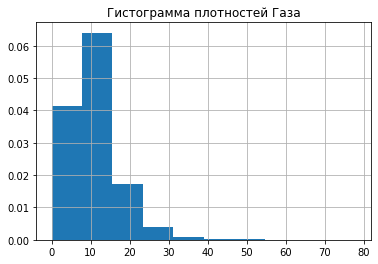

In [14]:
full_date(data_gas)
plt.title('Гистограмма плотностей Газа')
data_gas['Газ 1'].hist(density=True);

**Предварительные выводы** :
- Каждая строка соответсвует кол-ву подаваемого газа в одной плавке
- Всего 3239 строк, всего плавок 3241, получается на 2 плавки газ не подавался
- Среднее кол-во подаваемого газа 11 у.е., медиана 9.83 у.е., максимальное 77.99 у.е.
- Дубликатов и пропущенных значений нет.

In [15]:
#Плавки, на которые газ не подавался
fuse_without_gas = data_arc['key'][~data_arc['key'].isin(data_gas['key'])].unique()
fuse_without_gas

array([193, 259])

#### Температура

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


-------------------------------------------------------------------------------------------------------------
Вывод 10 строк


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


-------------------------------------------------------------------------------------------------------------
Количество дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количество пропущеных значений


key                0
Время замера       0
Температура     3427
dtype: int64

-------------------------------------------------------------------------------------------------------------
Распределение по плавкам:
2108    0.000940
1513    0.000884
1689    0.000884
2567    0.000829
322     0.000774
          ...   
556     0.000111
1169    0.000111
732     0.000111
195     0.000055
279     0.000055
Name: key, Length: 3216, dtype: float64


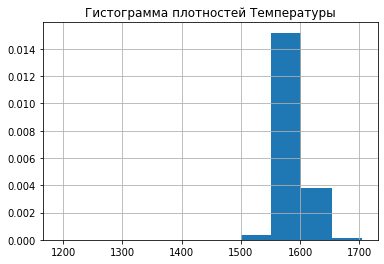

In [16]:
full_date(data_temp)
plt.title('Гистограмма плотностей Температуры')
data_temp['Температура'].hist(density=True);

In [17]:
#Преобразование типа данных
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

**Предварительные выводы** :
- Строка является информацией по плавке, временем замера температуры и самой температуры(предположительно в градусах). Возможно несколько замеров по одной плавке. Температуру замеряют перед началом плавки, а также после. 
- Всего 3427 пропусков. Данных по замерам без учета пропуска - 14665. 
- С учетом вывода по электродам, где 14876 (с учетом формулы Итого N(кол-во нагревов) + 1 = N(кол-во замеров температуры)) следует, что температуру мерили не по всем плавкам. Возможно датчик вышел из строя?
- Средняя температура 1590, медиана 1590, максимальное 1705, минимальное 1191
- Чаще всего измеряли температуру по плавке 2108

#### Данные о проволочных материалах (объём)

In [18]:
full_date(data_wire_volume)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


-------------------------------------------------------------------------------------------------------------
Вывод 10 строк


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------------------------------------------------------------------------
Количество дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количество пропущеных значений


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

-------------------------------------------------------------------------------------------------------------
Распределение по плавкам:
2049    0.000325
2664    0.000325
2590    0.000325
543     0.000325
2592    0.000325
          ...   
1090    0.000325
3139    0.000325
1092    0.000325
3141    0.000325
2047    0.000325
Name: key, Length: 3081, dtype: float64


**Предварительные выводы** :
- Каждая строка соответсвую номеру плавки, в которую добавляли ту или иную проволку.
- Всего 9 видов проволки `Wire 9`
- Всего 3081 строк, значит не во все плавки добавляли проволку.

#### Данные о проволочных материалах (время)

In [19]:
full_date(data_wire_time)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


-------------------------------------------------------------------------------------------------------------
Вывод 10 строк


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------------------------------------------------------------------------
Количество дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количество пропущеных значений


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

-------------------------------------------------------------------------------------------------------------
Распределение по плавкам:
2049    0.000325
2664    0.000325
2590    0.000325
543     0.000325
2592    0.000325
          ...   
1090    0.000325
3139    0.000325
1092    0.000325
3141    0.000325
2047    0.000325
Name: key, Length: 3081, dtype: float64


In [20]:
#Преобразуем тип даннных в datetime
for n in range(1,10):
    data_wire_time['Wire '+ str(n)] = pd.to_datetime(data_wire_time['Wire '+ str(n)], format='%Y-%m-%dT%H:%M:%S')

In [21]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


**Предварительные выводы** :
- Кол-во строк совпадает со строками по объему проволки. Максимальное кол-во плавок совпадает с предыдущим датасетом. Также совпадает кол-во пропусков, можно предположить, что по всем сыпучим материалам объем - соответсвует время подачи.

#### Производственный процесс

Рассмотрим производственный процесс на примере первой плавки

In [22]:
cicle_one_concat = pd.concat(
    [data_arc, data_bulk_volume, data_bulk_time, data_wire_volume, data_wire_time]
)
cicle_one_concat = (
    cicle_one_concat[cicle_one_concat["key"] == 1]
    .dropna(axis=1, how="all")
    .reset_index(drop=True)
)

In [23]:
cicle_one_concat

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Wire 1
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,NaT,NaT,NaT,NaT,NaT
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,NaT,NaT,NaT,NaT,NaT
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,NaT,NaT,NaT,NaT,NaT
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,NaT,NaT,NaT,NaT,NaT
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,NaT,NaT,NaT,NaT,NaT
5,1,NaT,NaT,NaN,NaN,43.0,206.0,150.0,154.0,NaT
6,1,NaT,NaT,NaN,NaN,2019-05-03 11:28:48,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43,NaT
7,1,NaT,NaT,NaN,NaN,NaT,NaT,NaT,NaT,60.059998
8,1,NaT,NaT,NaN,NaN,NaT,NaT,NaT,NaT,2019-05-03 11:06:19


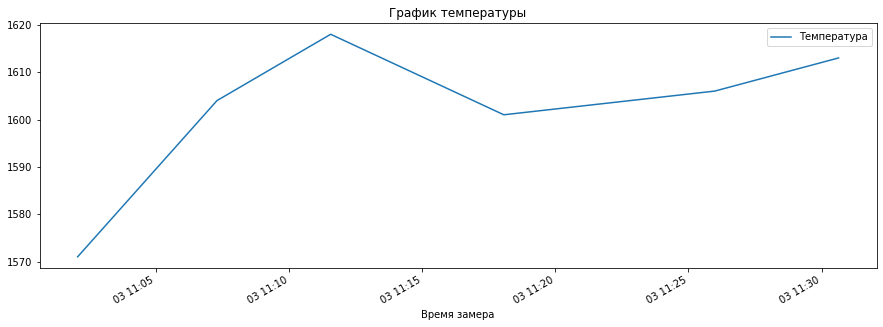

In [24]:
data_temp[data_temp['key'] == 1].plot(x='Время замера', y='Температура', figsize=(15,5))
plt.title('График температуры');

In [25]:
data_gas[data_gas['key'] == 1]

,key,Газ 1
0,1,29.749986


Имеем следующую хронологию событий:
1. Замер температуры `2019-05-03 11:02:04` - 1571
2. Нагрев дуги с `2019-05-03 11:02:14` до `2019-05-03 11:06:02` активной мощностью 0.30 у.е.
3. Добавление проволки Wire 1 через трайб-аппарат `2019-05-03 11:06:19` в объеме 60.06 у.е.
3. Замер температуры `2019-05-03 11:07:18` - 1604
4. Нагрев дуги с `2019-05-03 11:07:28` до `2019-05-03 11:10:33` активной мощностью 0.76 у.е.
5. Добавление сыпучих материалов Bulk 15 `2019-05-03 11:10:43` - 154.0 у.е.
6. Замер температуры `2019-05-03 11:11:34` - 1618
7. Нагрев дуги с `2019-05-03 11:11:44` до `2019-05-03 11:14:36` мощностью 0.58 у.е.
8. Добавление сыпучих материалов Bulk 14 `2019-05-03 11:14:50` - 150.0 у.е.
9. Замер температуры `2019-05-03 11:18:04` - 1601.0
10. Нагрев дуги с `2019-05-03 11:18:14` до `2019-05-03 11:24:19` мощностью 0.51 у.е.
11. Добавление сыпучих материалов Bulk 12 `2019-05-03 11:24:31` - 206.0 у.е.
12. Замер температуры `2019-05-03 11:25:59` - 1606
13. Нагрев дуги с `2019-05-03 11:26:09` до `2019-05-03 11:28:37` мощностью 0.86 у.е.
14. Добавление сыпучих материалов Bulk 4 `2019-05-03 11:28:48` - 43.0 у.е.
15. Замер температуры `2019-05-03 11:30:38` - 1613
16. Начало следующей плавки

**Вывод**:
- Всего 1 плавка занимала 16 этапов вместе с замером температуры.
- Между подаче Bulk 15 и замером температуры прошло 4 мин, хотя остальные этапы добавки более короткие
- Во все время плавки было потрачено 29,74 у.е. газа

#### Электроды

Построим гистограмму по времени нагрева дугой

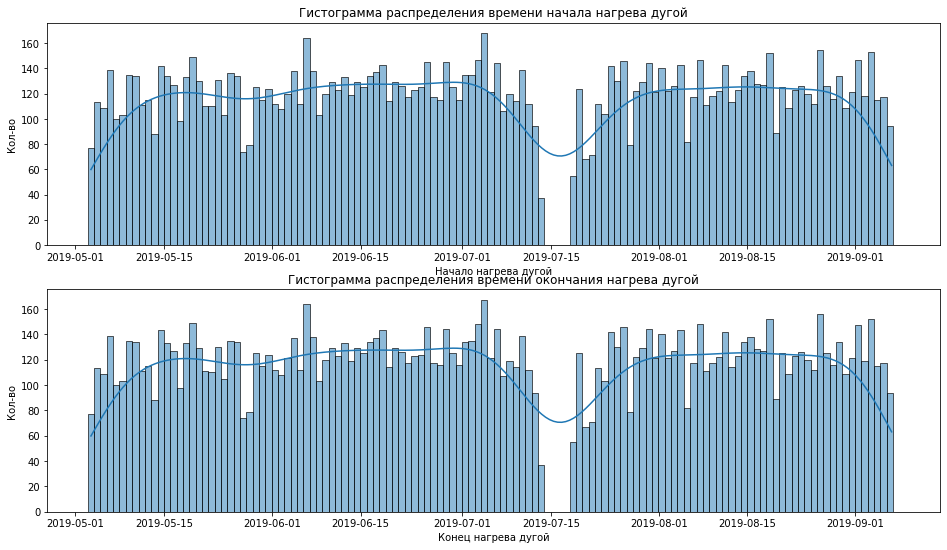

In [26]:
plt.figure(1, figsize=(16,9))
plt.subplot(211)
sns.histplot(data=data_arc, x='Начало нагрева дугой', kde=True, discrete=True)
plt.ylabel('Кол-во')
plt.title('Гистограмма распределения времени начала нагрева дугой')
plt.subplot(212)
sns.histplot(data=data_arc, x='Конец нагрева дугой', kde=True, discrete=True)
plt.ylabel('Кол-во')
plt.title('Гистограмма распределения времени окончания нагрева дугой');

Имеется пропуски июле. Можно предположить, что была газовая пауза. Проверим дни.

In [27]:
set(
    data_arc["Начало нагрева дугой"]
    .dt.day[data_arc["Начало нагрева дугой"].dt.month == 6] #Взял 6 месяц, так как данные полные
) - set(
    data_arc["Начало нагрева дугой"]
    .dt.day[data_arc["Начало нагрева дугой"].dt.month == 7]
)

{14, 15, 16, 17}

В дни с 14 до 17 включительно на электроды не подавалось электричество.

Рассмотрим распределение итераций плавок

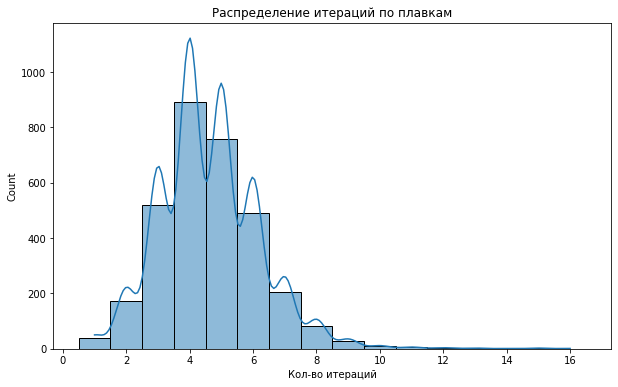

In [28]:
plt.figure(1, figsize=(10,6))
sns.histplot(data=data_arc.pivot_table(index = 'key', 
                                       values = 'Активная мощность', 
                                       aggfunc = 'count'), x='Активная мощность', kde=True, discrete=True)
plt.title('Распределение итераций по плавкам')
plt.xlabel('Кол-во итераций');

Чаще всего нагревали 4 раза последовательно 1 плавку, максимальное кол-во итераций нагрева дуги 16, имеются единичные случаи

Рассмотрим распределение мощности. Для этого расчитаем сразу полную мощность.

In [29]:
def full_power(row):
        
    full_power= math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

In [30]:
data_arc['Полная мощность'] = data_arc.apply(full_power, axis=1)

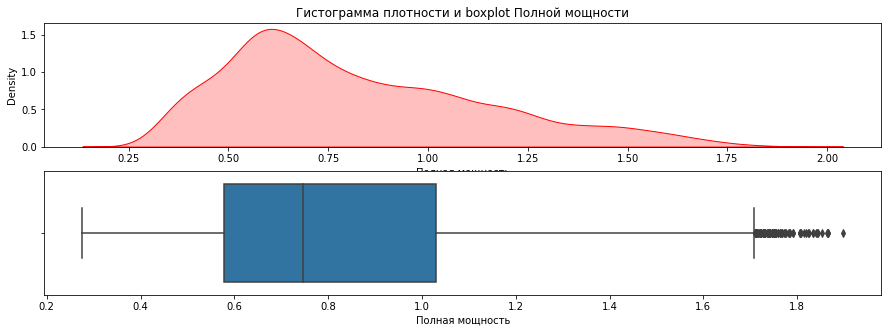

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(211)
sns.kdeplot(data_arc['Полная мощность'], color='red',legend=True,shade=True)
plt.title('Гистограмма плотности и boxplot Полной мощности')
plt.subplot(212)
sns.boxplot(data=data_arc, x='Полная мощность'); 

Замечаем, что после ~1.7 у.е. идут выбросы, но не значительные, поэтому оставляем в датасете.

#### Данные о подаче сыпучих материалов (объём)

Сыпучие материалы добавляются по разному в зависимости от требуемой стали. Поэтому построим коробку с усами

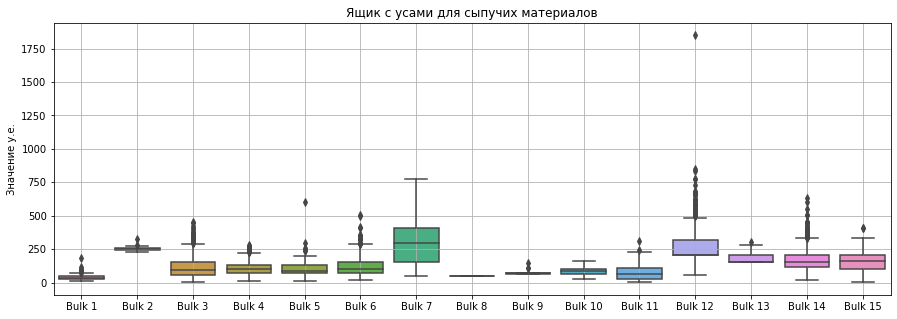

In [32]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk_volume.drop('key', axis=1))
plt.grid()
plt.title('Ящик с усами для сыпучих материалов')
plt.ylabel('Значение у.е.');

Замечаем явный выброс по сыпучему материалу Bulk 12(1849 у.е.), ранее мы отмечали его при первичном анализе.

In [33]:
data_bulk_volume[(data_bulk_volume['Bulk 12'] >= 1000) | (data_bulk_volume['Bulk 8'] > 0)]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN
1725,1786,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN


Даннные строчки по возможности исключим из тренировочной выборки

#### Данные о подаче сыпучих материалов (Время)

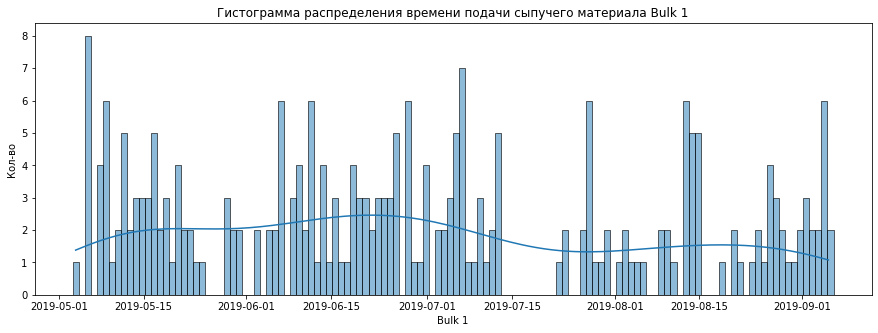

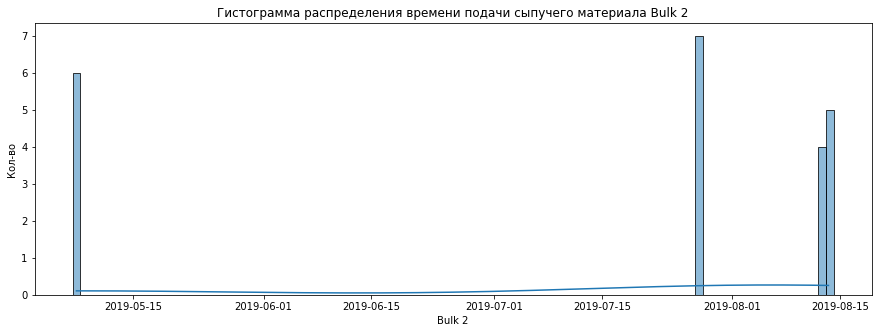

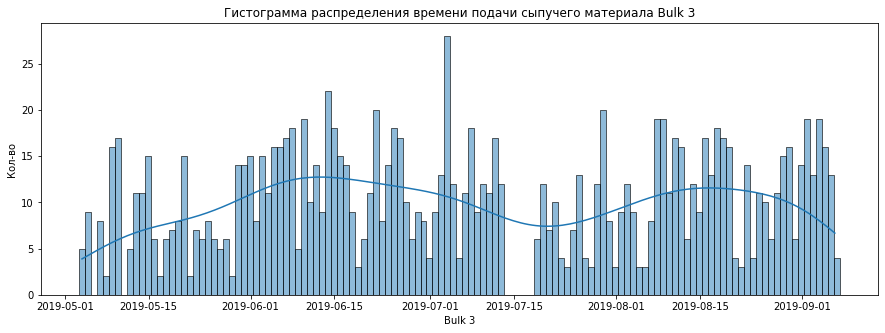

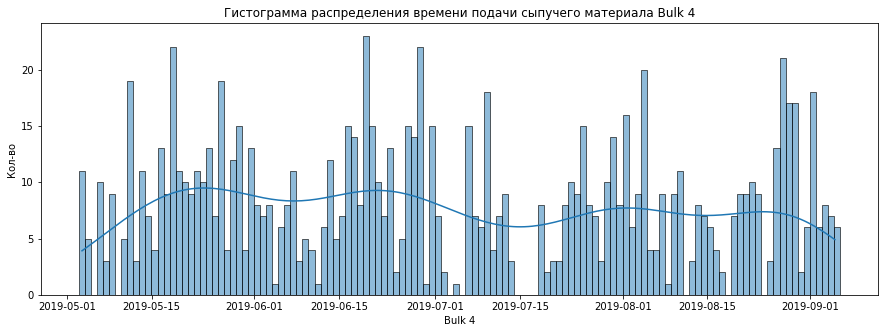

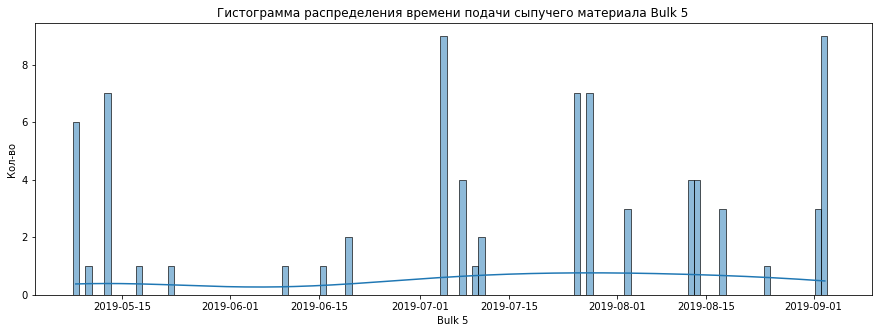

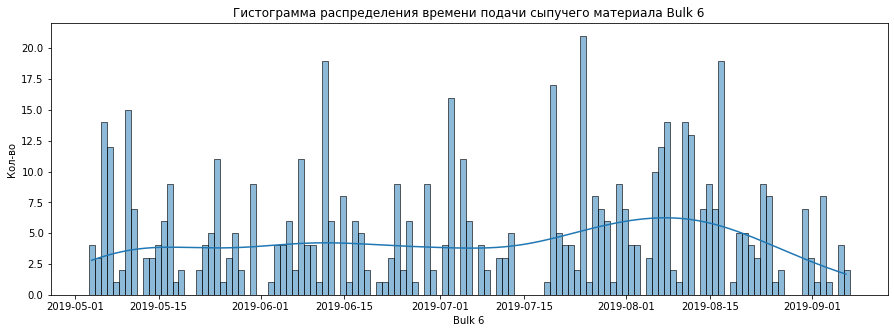

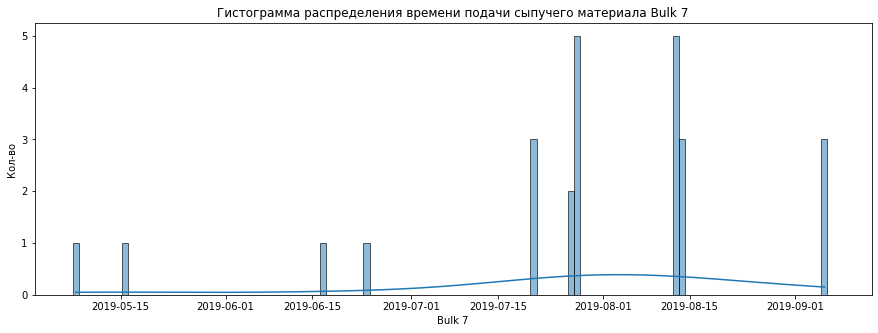

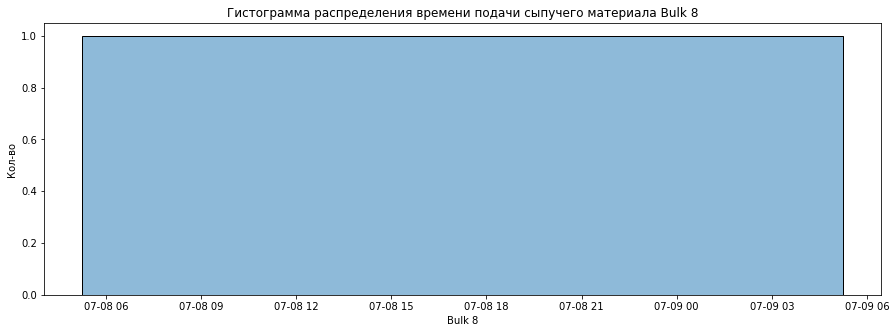

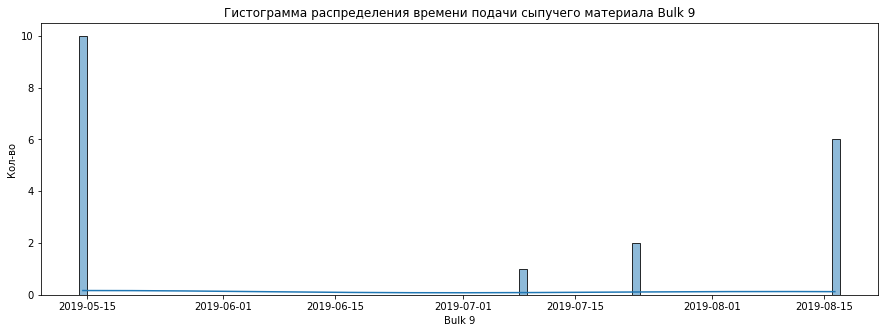

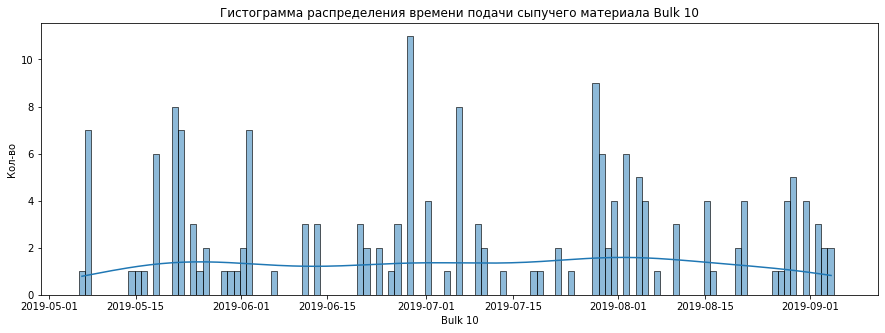

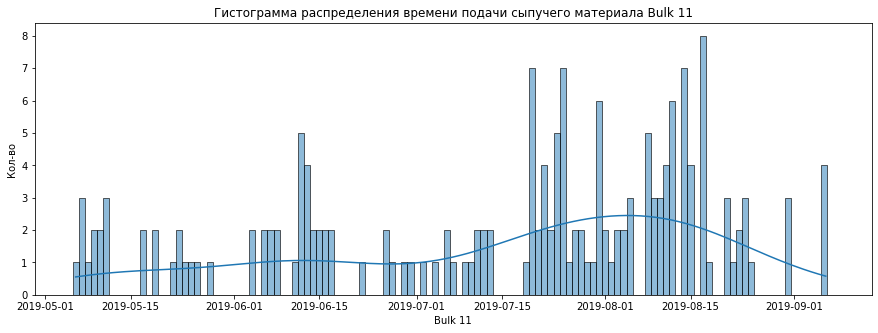

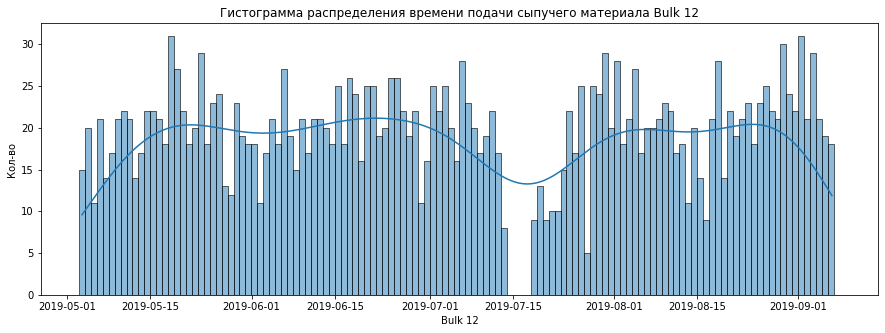

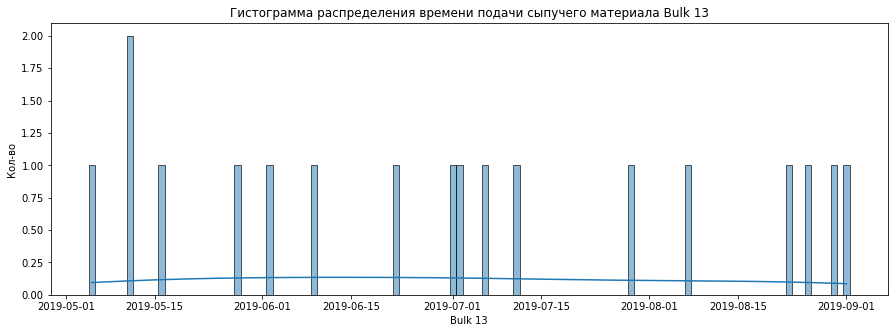

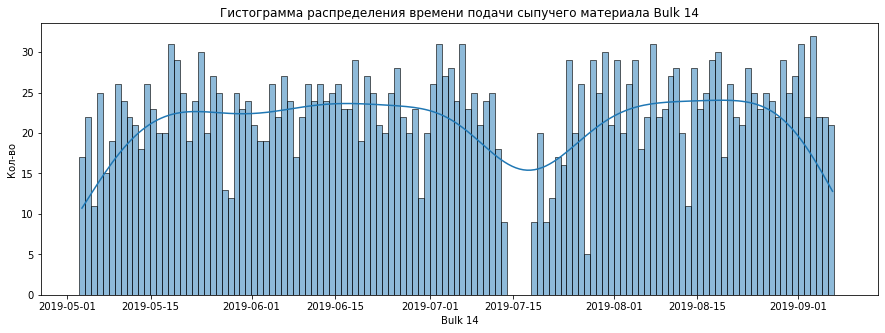

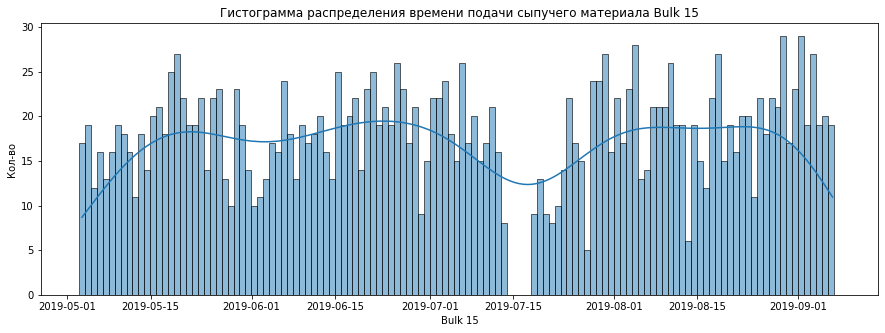

In [34]:
for i in range(1,16):
    plt.figure(1, figsize=(15,5))
    sns.histplot(data=data_bulk_time, x='Bulk '+ str(i), kde=True, discrete=True)
    plt.ylabel('Кол-во')
    plt.title('Гистограмма распределения времени подачи сыпучего материала Bulk ' + str(i))
    plt.show()

На гистограмме замечаем, что также отсутсвует подача сыпучих материалов как и нагревы дуги в следующие дни 14, 15, 16, 17 июля

#### Газ

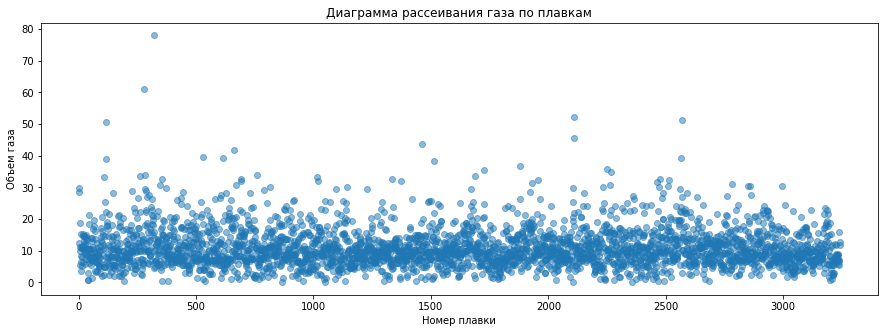

In [35]:
plt.figure(1, figsize=(15,5))
plt.scatter(data=data_gas, x='key', y='Газ 1', alpha=0.5)
plt.title('Диаграмма рассеивания газа по плавкам')
plt.ylabel('Объем газа') 
plt.xlabel('Номер плавки');

Замечаем, что имеются единичные случаи с потреблением газа на плавку объемом окло 80 и 60 у.е. Данные плавки оставим в датасете, будем считать уникальным производством.

#### Температура

In [36]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

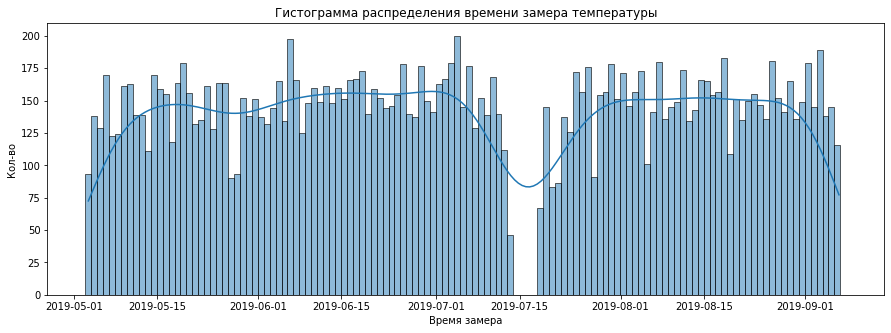

In [37]:
plt.figure(1, figsize=(15,5))
sns.histplot(data=data_temp, x='Время замера', kde=True, discrete=True)
plt.ylabel('Кол-во')
plt.title('Гистограмма распределения времени замера температуры');

в следующие дни 14, 15, 16, 17 июля не было замеров.

In [38]:
data_temp_pivot = data_temp.pivot_table(index='key',values='Время замера', aggfunc = 'count')
data_temp_pivot[data_temp_pivot['Время замера'] < 2]

,Время замера
key,
195,1
279,1


Всего 2 строки, 195, 279 плавка. Возможно сбой датчиков. Данные замеры в итоговой таблице будем исключать.

Всего 3427 пропусков. Данных по замерам без учета пропуска - 14665. Заполним пропуски заглушкой

In [39]:
data_temp = data_temp.fillna(0)

In [40]:
data_temp[data_temp['Температура'] == 0]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,0.0
13928,2500,2019-08-10 14:18:12,0.0
13929,2500,2019-08-10 14:25:53,0.0
13930,2500,2019-08-10 14:29:39,0.0
13932,2501,2019-08-10 14:49:15,0.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,0.0
18088,3241,2019-09-06 17:06:38,0.0
18089,3241,2019-09-06 17:21:48,0.0
18090,3241,2019-09-06 17:24:44,0.0


Замечаем, что именно с 2019-08-10 14:13:11 и 2500 плавки начинается спад до сентября 2019.
Данные плавки исключаем из датасета. Но сначала рассмотрим распределение.

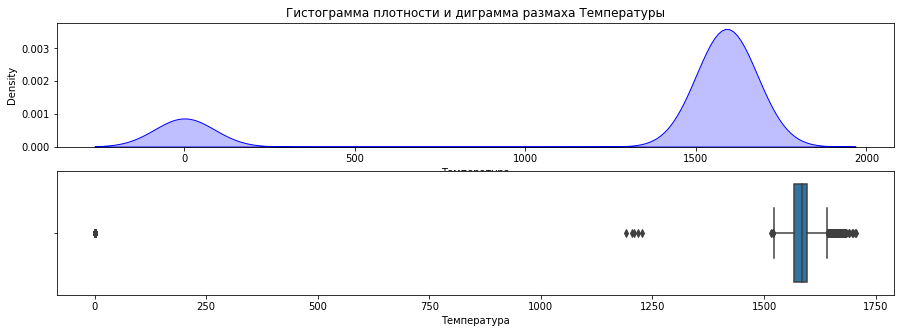

In [41]:
plt.figure(figsize=(15, 5))
plt.subplot(211)
sns.kdeplot(data_temp['Температура'], color='blue',legend=True,shade=True)
plt.title('Гистограмма плотности и диграмма размаха Температуры')
plt.subplot(212)
sns.boxplot(data=data_temp, x='Температура'); 

Замечаем выбросы ниже 1500 градусов. В основном температура около 1575 градусов.

In [44]:
#Рассмотрим партии, где температура ниже 1500 градусов в одной из итераций
flaw_key = data_temp[data_temp['Температура'] < 1500]['key'].unique()
print(f'Исключаем {flaw_key.shape[0]} плавок')
flaw_key

Исключаем 743 плавок


array([ 867, 1214, 1619, 2052, 2500, 2501, 2502, 2503, 2504, 2505, 2506,
       2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517,
       2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528,
       2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539,
       2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550,
       2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561,
       2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572,
       2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583,
       2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594,
       2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605,
       2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616,
       2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627,
       2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638,
       2639, 2640, 2641, 2642, 2643, 2644, 2645, 26

In [45]:
#Исключаем данные партии
data_temp = data_temp.query('key not in @flaw_key')

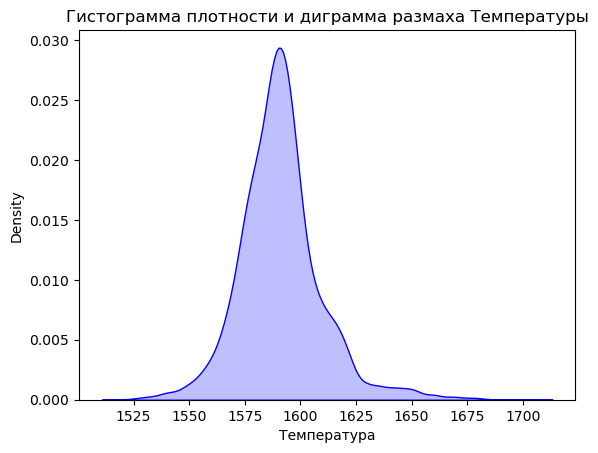

In [46]:
sns.kdeplot(data_temp['Температура'], color='blue',legend=True,shade=True)
plt.title('Гистограмма плотности и диграмма размаха Температуры');

#### Данные о проволочных материалах (объем)

Также как и сыпучие материалы, добавляют в зависимости от требуемой стали, поэтом построим диаграмму размаха

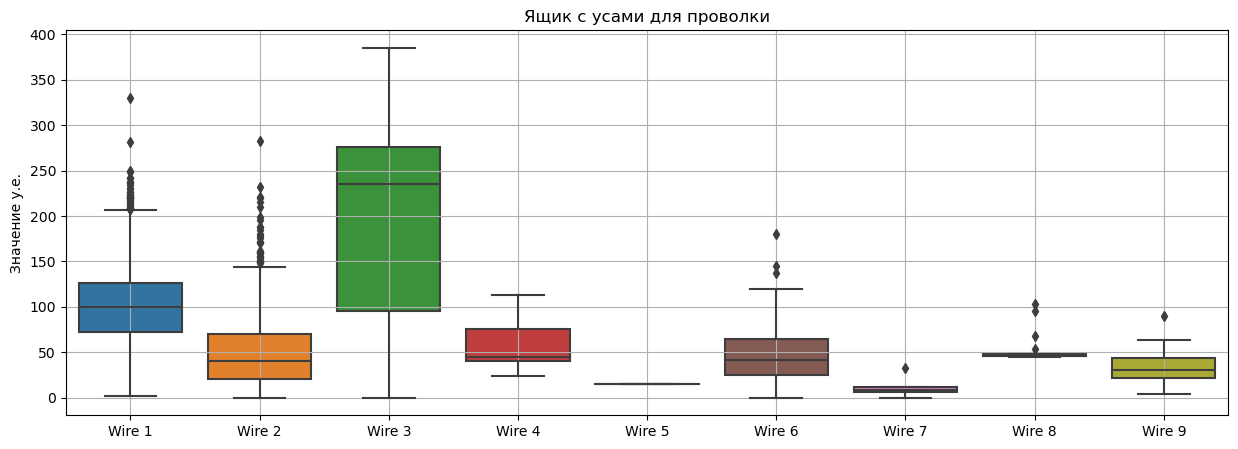

In [47]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire_volume.drop('key', axis=1))
plt.grid()
plt.title('Ящик с усами для проволки')
plt.ylabel('Значение у.е.');

Чаще всего добавляли проволку Wire 1 3055 раз, это видно из описания данных, Wire 5 меньше всего. Выбросы незначительные.

#### Данные о проволочных материалах (Время)

Проверим, если пропуски данных в июле, чтобы сделать однозначный вывод. Данные из этогов файла не будут использоваться в признаках модели.

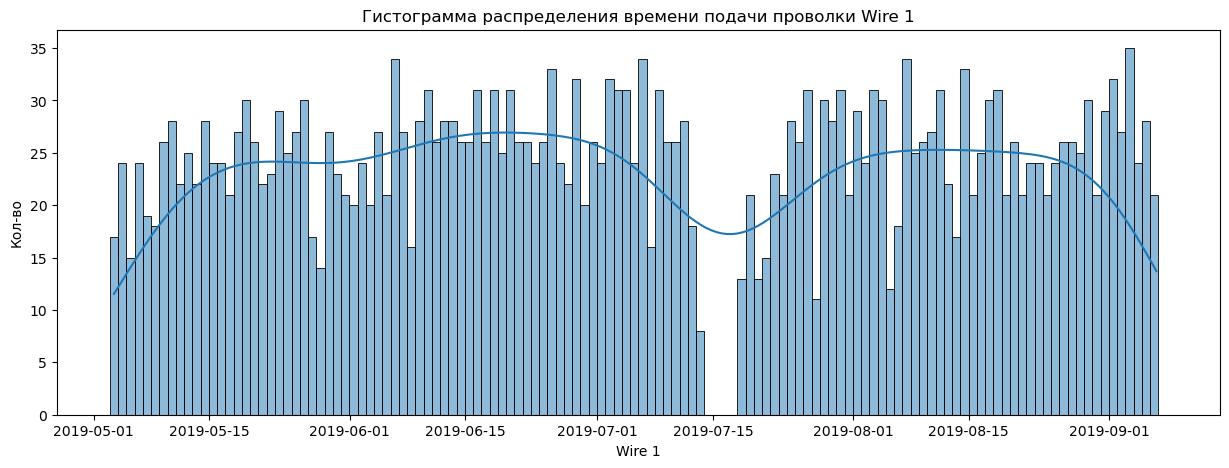

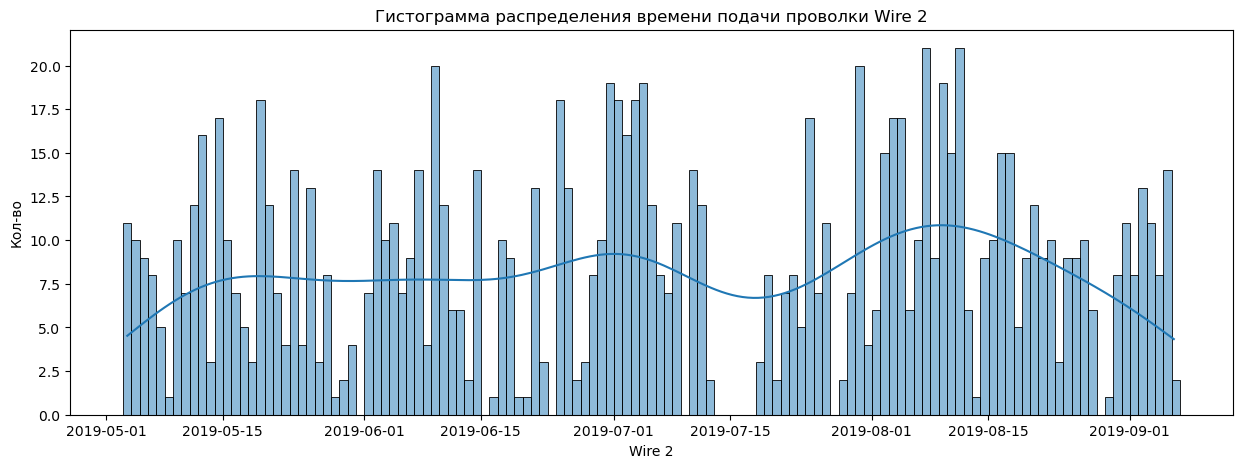

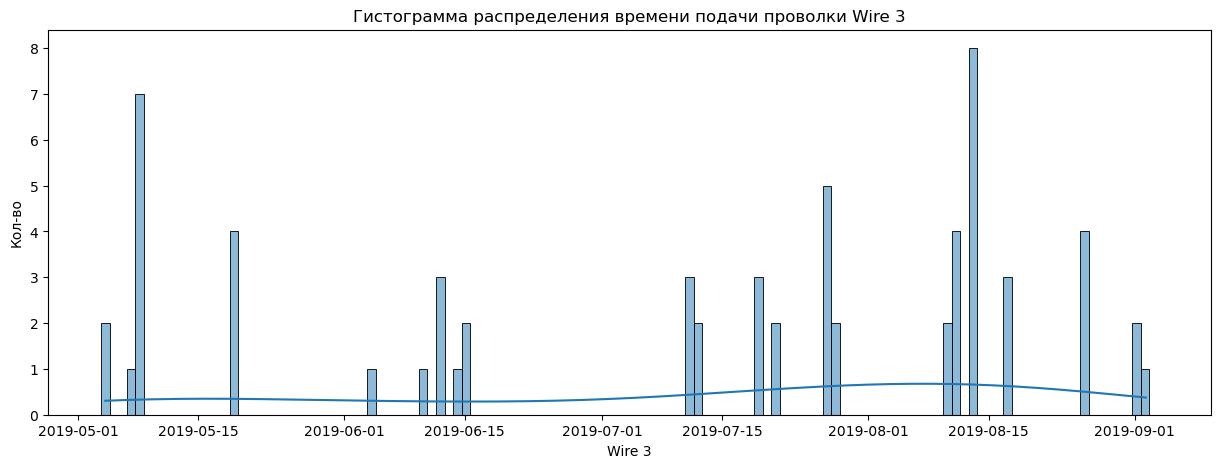

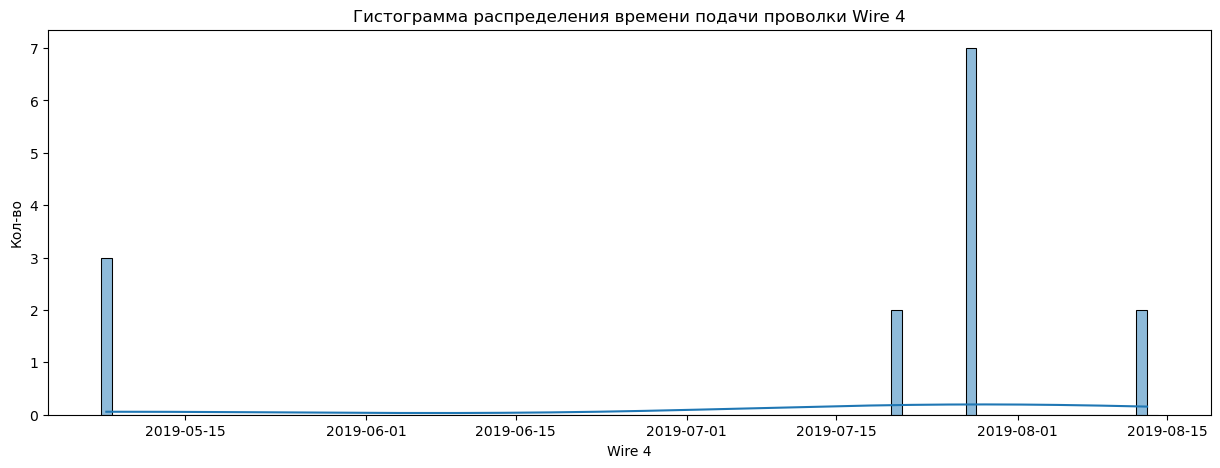

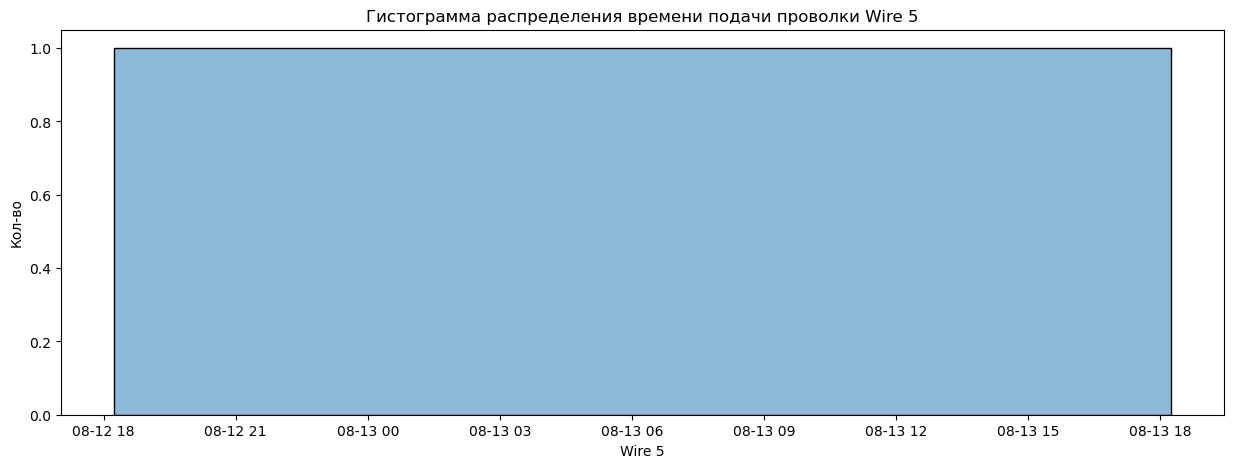

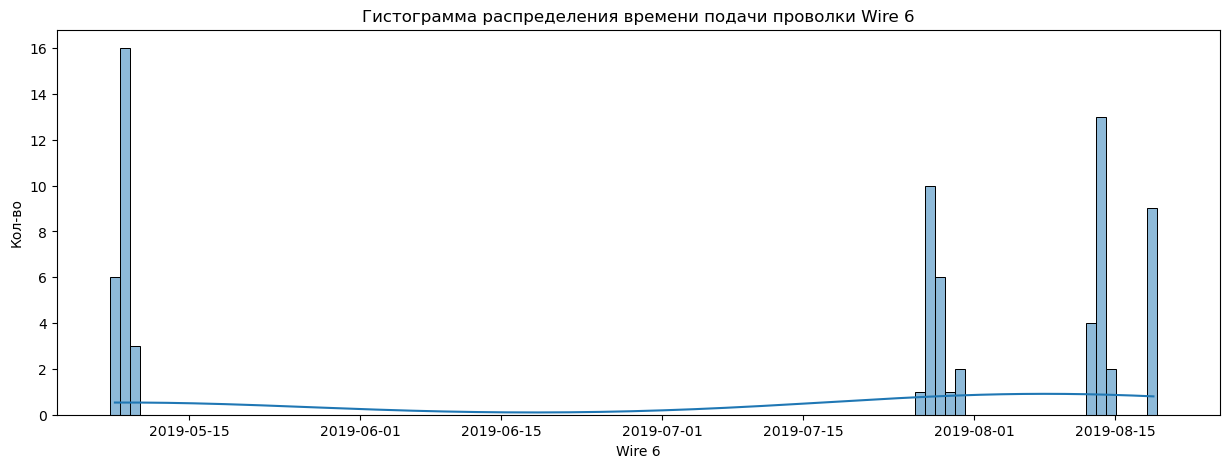

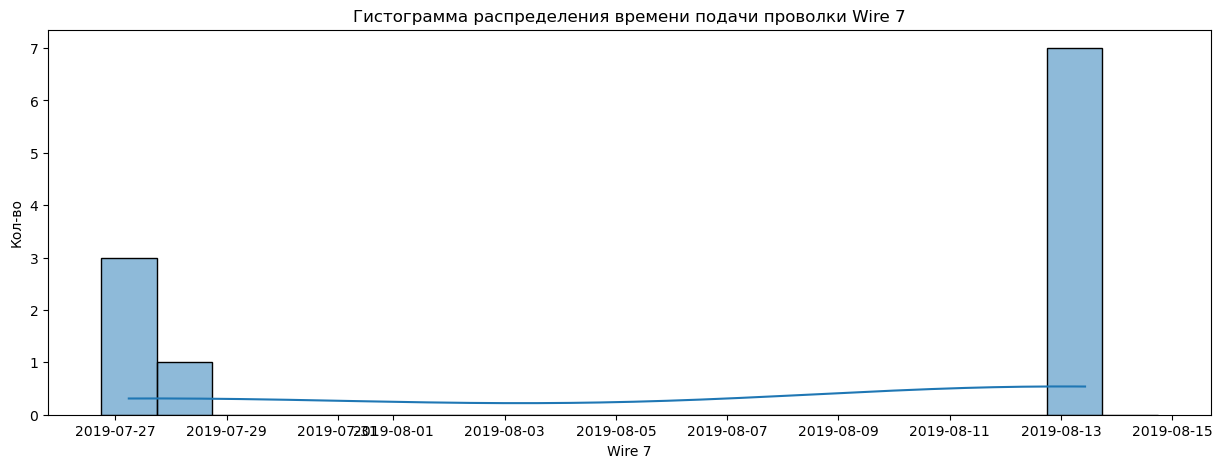

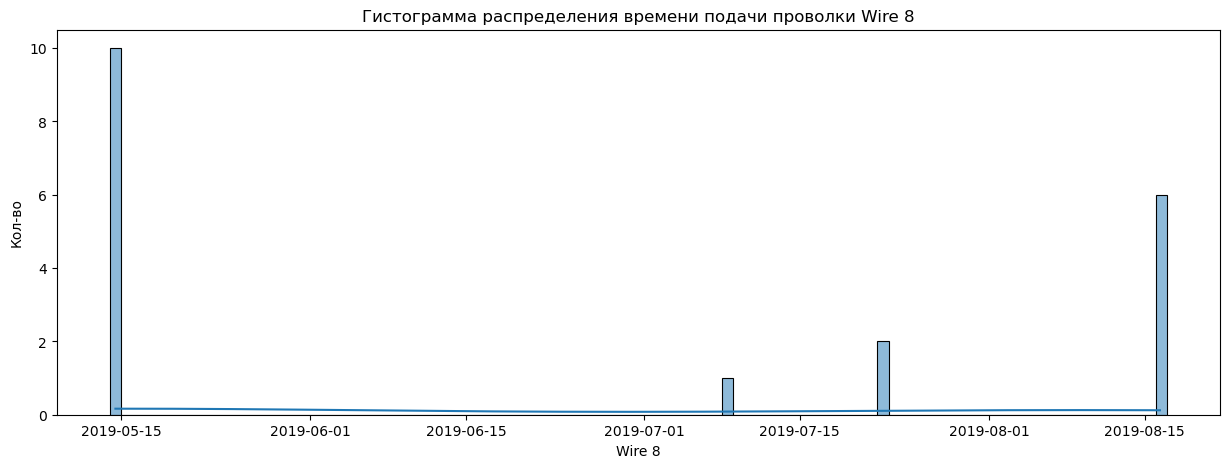

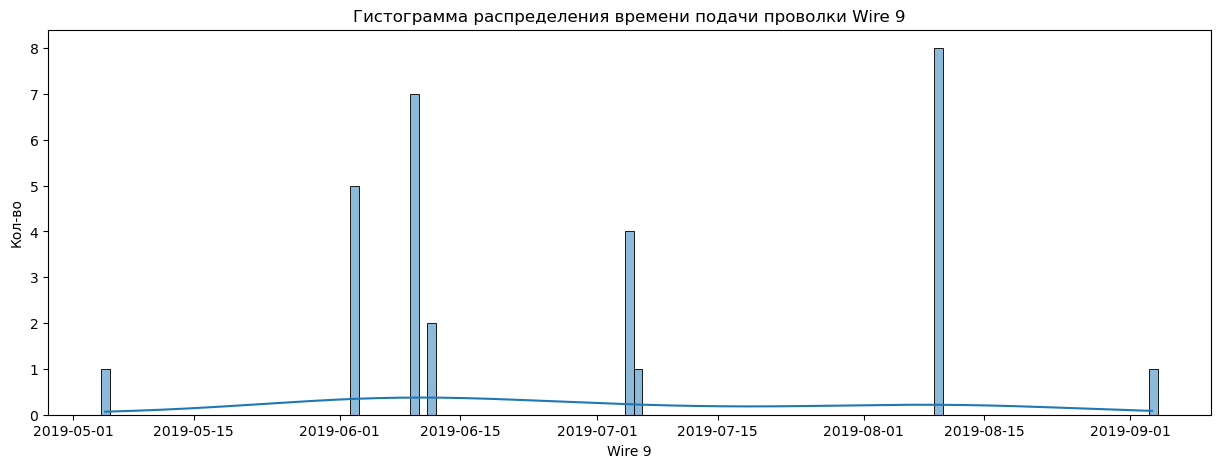

In [48]:
for i in range(1,10):
    plt.figure(1, figsize=(15,5))
    sns.histplot(data=data_wire_time, x='Wire '+ str(i), kde=True, discrete=True)
    plt.ylabel('Кол-во')
    plt.title('Гистограмма распределения времени подачи проволки Wire ' + str(i))
    plt.show()

14, 15, 16, 17 июля не было подачи проволки.

### Вывод по анализу данных

- Всего первая плавка занимала 16 этапов вместе с замером температуры. Примерное время на плавку 28 мин. Различается для разных плавок в зависимости от требуемой стали
- В дни с 14 до 17 июля 2019 года не производились плавки. Это подтверждают данные об электродах, времени подачи сыпучих материалов, проволки, а также время замеров.
- Чаще всего нагревали 4 раза последовательно 1 плавку, максимальное кол-во итераций нагрева дуги 16, имеются единичные случаи.
- Создали полную мощность из активной и реактивной для электродов
- По сыпучим материалам, где пропуски - заполняем нулями для итоговой таблицы.
- Bulk 8 и Bulk 12 со значением 1849 у.е. - данные строчки исключаем из итоговой таблицы, так как bulk8 всего 1 строчка, что может повлиять на обучение, bulk12 слишком большое значение, тоже повлияет
- Имеются единичные случаи с потреблением газа на плавку объемом окло 80 и 60 у.е. Данные плавки оставим в датасете, будем считать уникальным производством
- 195, 279 плавка единичные
- Заполнили пропуски заглушкой (0), итого 3427 замеров начинается с `2019-08-10 14:13:11` и по сентябрь. Данные заглушки исключили вместе с замерами температуры ниже 1500 градусов (743 плавок)
- По объему проволок: Wire 1 3055 раз, это видно из описания данных, Wire 5 меньше всего. Выбросы незначительные.

### Построение итоговой таблицы для дальнейшего обучения модели

#### Итоговая таблица

Заполним пропуски нулями в таблицах data_bulk_volume, data_wire_volume. Как оговаривали ранее следующие таблицы не будем брать для обучения модели: data_wire_time, data_bulk_time.

In [49]:
data_bulk_volume.fillna(0, inplace=True)
data_wire_volume.fillna(0, inplace=True)

In [50]:
#Проверка
data_bulk_volume.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

In [51]:
#Проверка
data_wire_volume.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

Соединять таблицы будем методом merge(how='inner'), что позволит исключить ненужныеу нам партии. Для начала разберемся с таблицей электродов

In [52]:
data_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность', 'Полная мощность'],
      dtype='object')

У нас есть время и полная мощность, значит мы можем расчитать работу, выполненную электродами в одной партии. Время в таблице оставим для дальнейшего расчета в секундах.

In [53]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

In [54]:
data_arc['Время нагрева'].head()

0    228
1    185
2    172
3    365
4    148
Name: Время нагрева, dtype: int64

In [55]:
data_arc['Работа электродов'] = data_arc['Полная мощность']*data_arc['Время нагрева']

In [56]:
data_arc['Работа электродов'].head()

0     84.616003
1    166.928978
2    124.276277
3    234.630603
4    159.830252
Name: Работа электродов, dtype: float64

In [57]:
data_arc_pivot = data_arc.pivot_table(index='key', 
                                      values=['Работа электродов', 'Время нагрева'], 
                                      aggfunc=np.sum).reset_index()

In [58]:
data_arc_pivot.head()

,key,Время нагрева,Работа электродов
0,1,1098,770.282114
1,2,811,481.760005
2,3,655,722.837668
3,4,741,683.455597
4,5,869,512.169934


Разберемся теперь с таблицей температур

In [59]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

Наша цель предсказать последню температуру в плавке. В итоговую таблицу пойдет : время между первым и последним замером, первая и последняя температура, где последняя температура - это целевой признак, а также кол-во замеров - как интерация между подачи сыпучих материалов и проволки.

In [60]:
data_temp_pivot_table = data_temp.pivot_table(index='key', 
                                              values=['Время замера', 'Температура'], 
                                              aggfunc=['first', 'last', 'count']).reset_index()
data_temp_pivot_table.columns = data_temp_pivot_table.columns.droplevel()
data_temp_pivot_table.columns = ['key', 'Первый замер', 
                                 'Изначальная температура', 
                                 'Последний замер','Конечная температура', 'Кол-во итераций','Кол-во итераций 2']
data_temp_pivot_table = data_temp_pivot_table.drop('Кол-во итераций 2', axis=1)

In [61]:
data_temp_pivot_table.head()

,key,Первый замер,Изначальная температура,Последний замер,Конечная температура,Кол-во итераций
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5


In [62]:
#Исключим единичные замеры
print(f'Кол-во строк, где производился один замер - {(data_temp_pivot_table["Кол-во итераций"] < 2).sum()}')
data_temp_pivot_table = data_temp_pivot_table[data_temp_pivot_table['Кол-во итераций'] >= 2]

Кол-во строк, где производился один замер - 2


Расчитаем время между замерами

In [63]:
data_temp_pivot_table['Время между замерами'] = (data_temp_pivot_table['Последний замер'] -
                                                 data_temp_pivot_table['Первый замер']).dt.seconds

In [64]:
#Проверим нет ли нулевых значений между замерами
data_temp_pivot_table[data_temp_pivot_table['Время между замерами'] == 0].count()

key                        0
Первый замер               0
Изначальная температура    0
Последний замер            0
Конечная температура       0
Кол-во итераций            0
Время между замерами       0
dtype: int64

In [65]:
#исключаем ненужные столбцы
data_temp_pivot_table = data_temp_pivot_table.drop(['Первый замер', 'Последний замер'], axis=1)
data_temp_pivot_table.head()

,key,Изначальная температура,Конечная температура,Кол-во итераций,Время между замерами
0,1,1571.0,1613.0,6,1714
1,2,1581.0,1602.0,5,1265
2,3,1596.0,1599.0,6,1753
3,4,1601.0,1625.0,5,1220
4,5,1576.0,1602.0,5,1536


Теперь соединим сводные таблицы с электродом и температурой.

In [66]:
pivot_data = data_temp_pivot_table.merge(data_arc_pivot, on='key', how='inner')
pivot_data.head()

,key,Изначальная температура,Конечная температура,Кол-во итераций,Время между замерами,Время нагрева,Работа электродов
0,1,1571.0,1613.0,6,1714,1098,770.282114
1,2,1581.0,1602.0,5,1265,811,481.760005
2,3,1596.0,1599.0,6,1753,655,722.837668
3,4,1601.0,1625.0,5,1220,741,683.455597
4,5,1576.0,1602.0,5,1536,869,512.169934


При разборе производства первой плавки мы заметили, что между температура меняется в зависимости от итерации, конечная температура - не всегда максимальная. То есть через какое-то время плавка остывает. Это время и пойдет в финальную таблицу.  

Расчитывается как (Время между замерами - Время нагрева). Данные столбцы потом исключим, так как работа уже включает себя время нагрева.

In [67]:
pivot_data['Время простоя'] = pivot_data['Время между замерами'] - pivot_data['Время нагрева']
pivot_data = pivot_data.drop(['Время между замерами', 'Время нагрева'], axis=1)

In [68]:
pivot_data.head()

,key,Изначальная температура,Конечная температура,Кол-во итераций,Работа электродов,Время простоя
0,1,1571.0,1613.0,6,770.282114,616
1,2,1581.0,1602.0,5,481.760005,454
2,3,1596.0,1599.0,6,722.837668,1098
3,4,1601.0,1625.0,5,683.455597,479
4,5,1576.0,1602.0,5,512.169934,667


Соединяем с последними таблицами(сыпучими матриалами, проволкой и газом), там группировка не требуется, так как строка - информация об одной плавке.

In [69]:
pivot_data = (
    pivot_data.merge(data_bulk_volume, on="key", how="inner")
    .merge(data_wire_volume, on="key", how="inner")
    .merge(data_gas, on="key", how="inner")
)

In [70]:
pivot_data.head()

,key,Изначальная температура,Конечная температура,Кол-во итераций,Работа электродов,Время простоя,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,1571.0,1613.0,6,770.282114,616,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,5,481.760005,454,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,6,722.837668,1098,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,5,683.455597,479,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,5,512.169934,667,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [71]:
(pivot_data['Wire 5']>0).sum()

0

В итоговой таблице Wire 5 только нулевые значения.

In [72]:
pivot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   key                      2325 non-null   int64  
 1   Изначальная температура  2325 non-null   float64
 2   Конечная температура     2325 non-null   float64
 3   Кол-во итераций          2325 non-null   int64  
 4   Работа электродов        2325 non-null   float64
 5   Время простоя            2325 non-null   int64  
 6   Bulk 1                   2325 non-null   float64
 7   Bulk 2                   2325 non-null   float64
 8   Bulk 3                   2325 non-null   float64
 9   Bulk 4                   2325 non-null   float64
 10  Bulk 5                   2325 non-null   float64
 11  Bulk 6                   2325 non-null   float64
 12  Bulk 7                   2325 non-null   float64
 13  Bulk 8                   2325 non-null   float64
 14  Bulk 9                  

#### Корреляция признаков

Посмотрим на корреляцию признаков

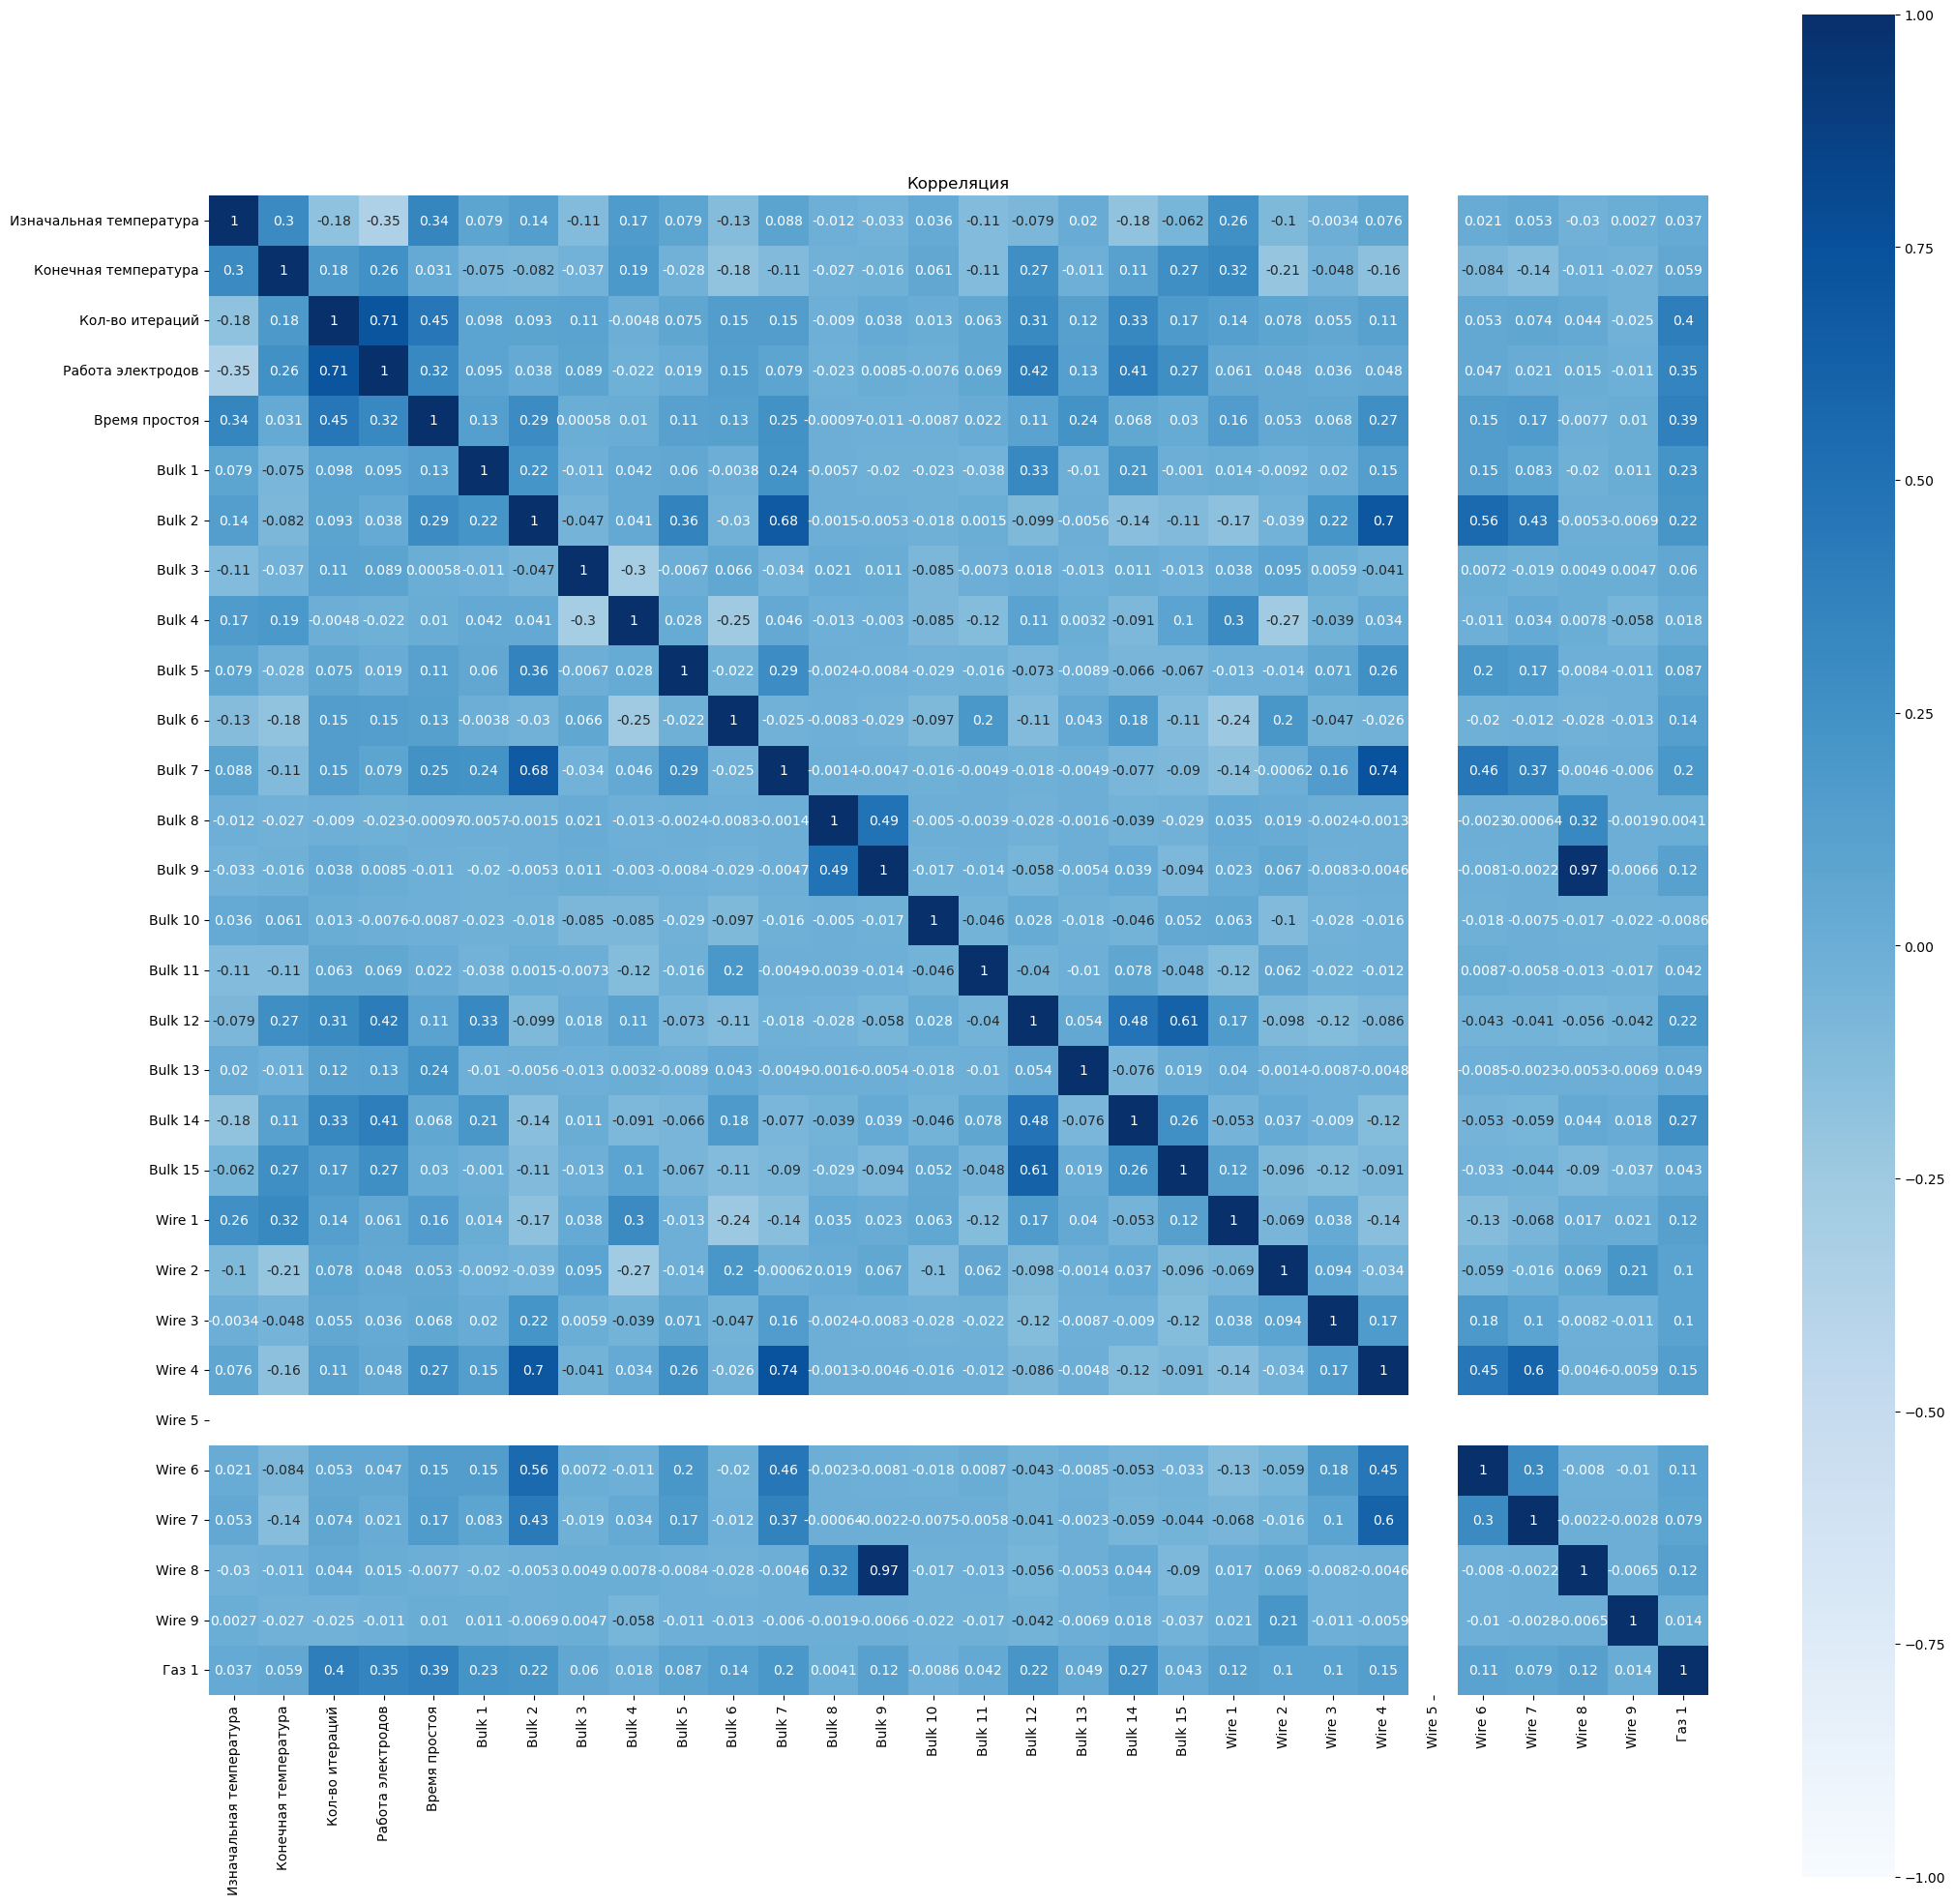

In [73]:
plt.figure(figsize=(25, 25))
sns.heatmap(pivot_data.drop('key', axis=1).corr(), annot=True, square=True, vmin=-1, vmax=1, cmap="Blues")
plt.title('Корреляция')
plt.show()

По таблице замечаем, что есть сильная корреляция. Рассмотрим их подробнее.

In [74]:
pivot_data.corr().unstack()[(pivot_data.corr().unstack() != 1) & (abs(pivot_data.corr().unstack()) > 0.5)]

Кол-во итераций    Работа электродов    0.711678
Работа электродов  Кол-во итераций      0.711678
Bulk 2             Bulk 7               0.679353
                   Wire 4               0.699340
                   Wire 6               0.558883
Bulk 7             Bulk 2               0.679353
                   Wire 4               0.740570
Bulk 9             Wire 8               0.974968
Bulk 12            Bulk 15              0.614182
Bulk 15            Bulk 12              0.614182
Wire 4             Bulk 2               0.699340
                   Bulk 7               0.740570
                   Wire 7               0.602964
Wire 6             Bulk 2               0.558883
Wire 7             Wire 4               0.602964
Wire 8             Bulk 9               0.974968
dtype: float64

Пропорциональная зависимость между:
- Кол-во итераций и Работа электродов
- Bulk 2 с Bulk 7, Wire 4, Wire 6
- Сильная зависимость между Bulk 9 и Wire 8 - 0,97  

Сильной корреляции между целевым признаком и другими нет.

Наблюдается слабая корреляция между целевым признаком и начальной температурой, работой электродов, Bulk 15 и Wire 1 в районе 0,3.

#### Вывод

- в итоговую таблицу вошли 2325 объектов и 30 признаков (не включая номер партии).
- по сыпучим материалам и проволки пропуски заполнили нулями
- Создали дополнительно признаки Время нагрева, Работа электродов, Время простоя, Кол-во итераций
- Исключили дополнительно 2 строк изначального датасета по температуре, где кол-во замеров было равно единице, вошли плавки с 2500
- В итоговой таблице Wire 5 только нулевые значения.
- Сильной корреляции между целевым признаком и другими нет. Наблюдается слабая корреляция между целевым признаком и начальной температурой, работой электродов, Bulk 15 и Wire 1 в районе 0,3.  

Будем обучать модели с помощью кросс-валидации, всего берем 10 подвыборок, так как мало итоговых объектов для обучения.

### Подготовка данных и применение модели машинного обучения

#### Делим в пропорции 75:25

In [75]:
features = pivot_data.drop(['Конечная температура', 'key'], axis=1)
target = pivot_data['Конечная температура']

In [76]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

In [77]:
#Исключим для обучения следующие строки
target_train = target_train.drop(
    features_train[
        (features_train["Bulk 12"] >= 1000) | (features_train["Bulk 8"] > 0)
    ].index,
    axis=0,
)
features_train = features_train.drop(
    features_train[
        (features_train["Bulk 12"] >= 1000) | (features_train["Bulk 8"] > 0)
    ].index,
    axis=0,
)

In [78]:
#Проверим размерность выборок
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1742, 29), (582, 29), (1742,), (582,))

#### Стандартизация признаков

Все признаки количественные

In [79]:
#введем объект scaler
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler()

In [80]:
#Масштабируем числ признаки обучающей выборки
features_train_lr = features_train.copy()
features_train_lr = scaler.transform(features_train_lr)

In [81]:
#Масштабируем численные признаки тестовой выборки 
features_test_lr = features_test.copy()
features_test_lr = scaler.transform(features_test_lr)

Данные преобразованы для линейной регрессии. В остальных моделях будем использовать данные без преобразования.

#### Линейная регрессия

In [82]:
%%time

lr = LinearRegression()
lr_params = {}
grid_lr = GridSearchCV(estimator = lr, param_grid=lr_params, cv=10, scoring='neg_mean_absolute_error')
grid_lr.fit(features_train_lr, target_train)
predict_lr = grid_lr.predict(features_train_lr)

MAE_lr = mean_absolute_error(target_train, predict_lr)

print('Лучшее значение MAE при кросс-валидации -', -grid_lr.best_score_)
print('MAE для линейной регрессии -', MAE_lr)

Лучшее значение MAE при кросс-валидации - 6.523992437177993
MAE для линейной регрессии - 6.2278701339053315
CPU times: total: 32.6 s
Wall time: 7.49 s


#### Случайный лес

In [83]:
%%time

rfr = RandomForestRegressor() 

rfr_params = {'criterion':['squared_error', 'absolute_error'],
               'n_estimators':[110, 210],
               'random_state':[RANDOM_STATE]}

grid_rfr = GridSearchCV(estimator = rfr, param_grid = rfr_params, scoring='neg_mean_absolute_error', cv=10)

grid_rfr.fit(features_train, target_train)

predict_rfr = grid_rfr.predict(features_train)

MAE_rfr = mean_absolute_error(target_train, predict_rfr)

print('Параметры:', grid_rfr.best_params_)

print('Лучшее значение MAE при кросс-валидации -', -grid_rfr.best_score_)
print('MAE для случайного леса', MAE_rfr)

Параметры: {'criterion': 'squared_error', 'n_estimators': 210, 'random_state': 10823}
Лучшее значение MAE при кросс-валидации - 6.417437360231448
MAE для случайного леса 2.3664343119567013
CPU times: total: 2min 39s
Wall time: 9min 59s


#### LGBMRegressor

In [84]:
%%time

lgbm = LGBMRegressor()
params_lgbm = {
    'n_estimators' : [100, 150],
    'num_leaves':[x for x in range(13,16)], 
    'learning_rate':[x/100 for x in range(4, 6)],
    'random_state':[RANDOM_STATE],
    'verbose': [0],
    'boosting_type' : ['gbdt'],
    'force_col_wise':['+']}
    
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, cv=10, scoring='neg_mean_absolute_error')
grid_lgbm.fit(features_train, target_train)

predict_lgbm = grid_lgbm.predict(features_train)

MAE_lgbm = mean_absolute_error(target_train, predict_lgbm)

print('Параметры:', grid_lgbm.best_params_)

print('Лучшее значение MAE при кросс-валидации -', -grid_lgbm.best_score_)
print('MAE', MAE_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in

Уведомление связаны с наличием пробелов в признаках. Данные пробелы модель сама заменяет нишним подчеркиванием.

#### Catboost

In [85]:
%%time

catb = CatBoostRegressor()
params_catb = {
    'loss_function': ['RMSE', 'MAE'],
    'learning_rate':[x/100 for x in range(8, 21)],
    'n_estimators' : [x for x in range(100,151,10)],
    'random_state' : [RANDOM_STATE],
    'verbose':[0]
}
grid_catb = GridSearchCV(estimator=catb, param_grid=params_catb, cv=10, scoring='neg_mean_absolute_error')
grid_catb.fit(features_train, target_train)

predict_catb = grid_catb.predict(features_train)

MAE_catb = mean_absolute_error(target_train, predict_catb)

print('Параметры:', grid_catb.best_params_)

print('Лучшее значение MAE при кросс-валидации -', -grid_catb.best_score_)
print('MAE', MAE_catb)

Параметры: {'learning_rate': 0.09, 'loss_function': 'MAE', 'n_estimators': 150, 'random_state': 10823, 'verbose': 0}
Лучшее значение MAE при кросс-валидации - 6.156845450109641
MAE 4.334474552084179
CPU times: total: 11min 51s
Wall time: 15min 4s


#### Вывод по моделям

Посмтроим таблицу результатов для моделей.

In [86]:
results = {
    'Model' : ['LightGBM', 'Catboost', 'RandomForest','LinearRegression'],
    'Train MAE' :pd.Series([-grid_lgbm.best_score_, 
                            -grid_catb.best_score_, 
                            -grid_rfr.best_score_, 
                            -grid_lr.best_score_])
}
total_model = pd.DataFrame(results).sort_values(by='Train MAE', ascending=True)
total_model

,Model,Train MAE
1,Catboost,6.156845
0,LightGBM,6.241160
2,RandomForest,6.417437
3,LinearRegression,6.523992


**Вывод**:
- Всего применили 4 модели для задачи регрессии
- Использовали кроссвалидации cv = 10.
- Хуже всего показал результат модель линейной регрессии. МАЕ = 6.52 при кросс-валидации.
- Лучшее значение MAE при кросс-валидации показала модель Catboost - 6.15, при гиперпараметрах 
    - learning_rate': 0.09, 'loss_function': 'MAE', 'n_estimators': 150

модель Catboost и будем использовать для финального тестирования.

### Тестирование модели

#### Тест

In [87]:
%%time

test_model = CatBoostRegressor(**grid_catb.best_params_)

test_model.fit(features_train, target_train)

predict_test = test_model.predict(features_test)

MAE_test = mean_absolute_error(target_test, predict_test)

print('MAE', MAE_test)

MAE 6.488186619414321
CPU times: total: 656 ms
Wall time: 836 ms


Итоговое MAE составляет 6.488, что удовлетворяет условию поставленной задачи.

#### Проверка на вменяемость

Так как нашей метриков является MAE, то стратегией для даммми модели возьмем медиану.

In [88]:
dummy = DummyRegressor(strategy='median')
dummy.fit(features_train, target_train)   
predict = dummy.predict(features_test)   
MAE_dummy = mean_absolute_error(target_test, predict)   
print('MAE -', MAE_dummy)

MAE - 8.084192439862543


MAE дамми-модели больше чем у тестовой модели.

#### Оценка важности параметров

Посмотрим какие признаки больше всего влияют на предсказания

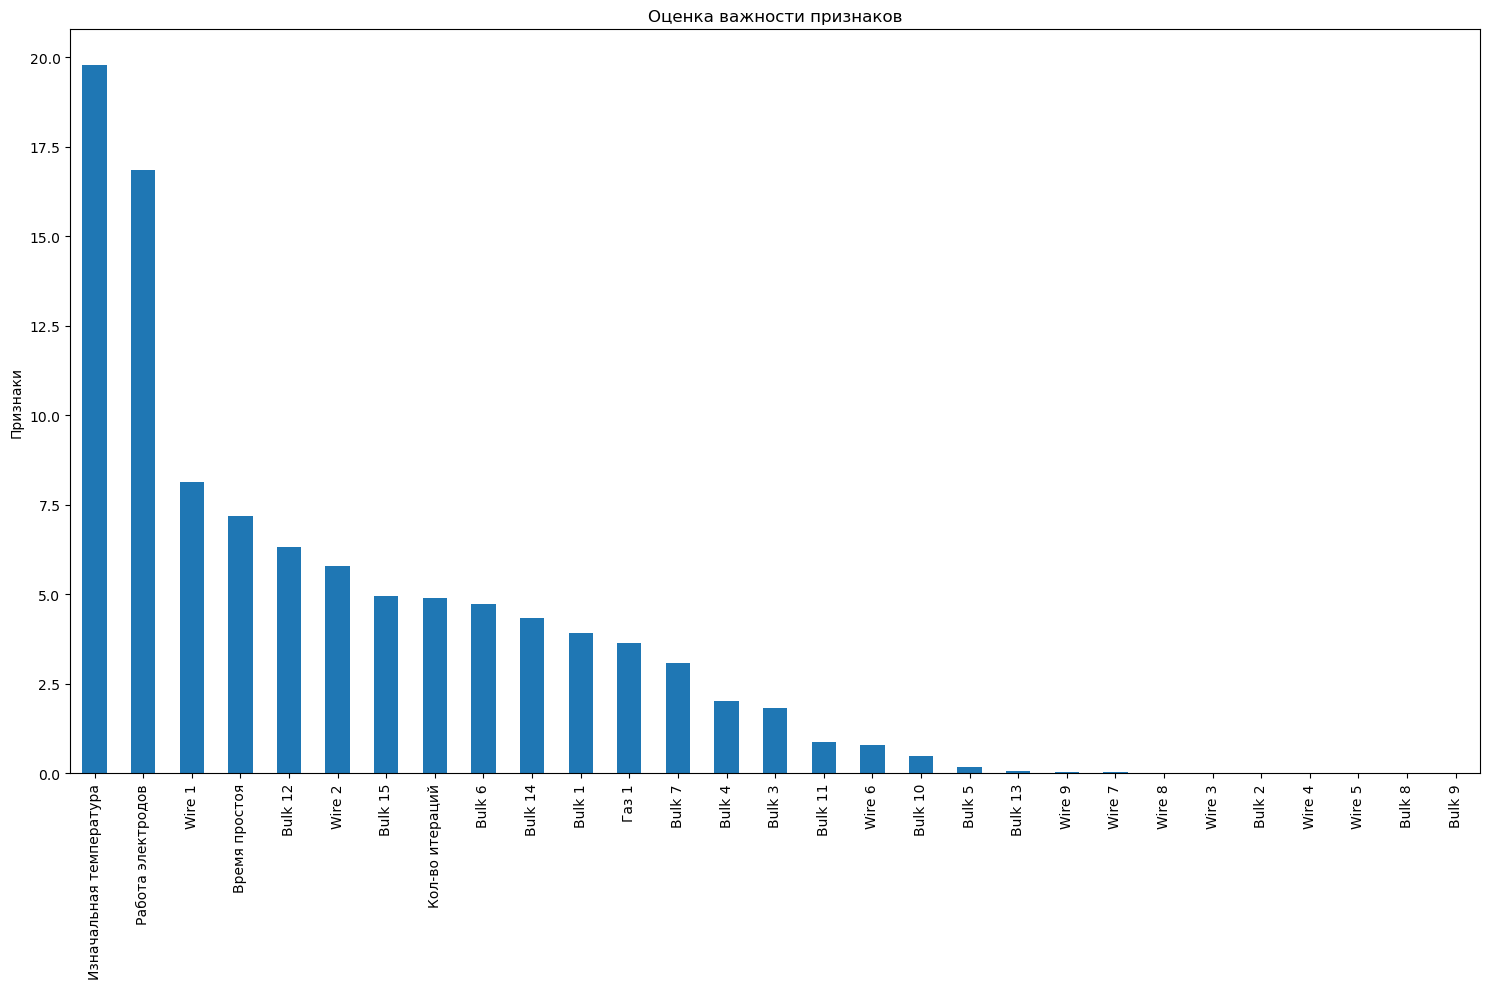

In [89]:
model_imp = pd.Series(test_model.feature_importances_, index=features_test.columns).sort_values(ascending=False)
plt.figure(figsize=(15, 10))
model_imp.plot.bar()
plt.title('Оценка важности признаков')
plt.ylabel('Признаки')
plt.tight_layout()

Важными признаками является:
- Изначальная температура
- Работа, совершенная электродами
- Сыпучие материалы Wire 1
- Время простоя

### Итоговый вывод

Целью проекта было создать модель для прогноза конечной температуры плавки.

При выполнении проекта можно сделать следующие тезисы:
- Всего первая плавка занимала 16 этапов вместе с замером температуры. Примерное время на плавку 28 мин. Различается для разных плавок в зависимости от требуемой стали
- В дни с 14 до 17 июля 2019 года не производились плавки. Это подтверждают данные об электродах, времени подачи сыпучих материалов, проволки, а также время замеров.
- Чаще всего нагревали 4 раза последовательно 1 плавку, максимальное кол-во итераций нагрева дуги 16, имеются единичные случаи.
- Создали полную мощность из активной и реактивной для электродов
- По сыпучим материалам, где пропуски - заполняем нулями для итоговой таблицы.
- Bulk 8 и Bulk 12 со значением 1849 у.е. - данные строчки исключаем из итоговой таблицы, так как bulk8 всего 1 строчка, что может повлиять на обучение, bulk12 слишком большое значение, тоже повлияет
- Имеются единичные случаи с потреблением газа на плавку объемом окло 80 и 60 у.е. Данные плавки оставим в датасете, будем считать уникальным производством
- 195, 279 плавка единичные
- Заполнили пропуски заглушкой (0), итого 3427 замеров начинается с `2019-08-10 14:13:11` и по сентябрь. Данные заглушки исключили вместе с замерами температуры ниже 1500 градусов.
- По объему проволок: Wire 1 3055 раз, это видно из описания данных, Wire 5 меньше всего. Выбросы незначительные.

Создали итоговую таблицу:
- в итоговую таблицу вошли 2325  объектов и 30 признаков (не включая номер партии).
- по сыпучим материалам и проволки пропуски заполнили нулями
- Создали признаки для итоговой таблицы
	- Работа электродов (Энергия, потраченная на нагрев стали)
	- Время простоя (Показывает сколько времени не подавалась энергия для нагрева, так как конечная температура не всегда является максимальной)
	- Кол-во итераций (Сколько раз добавляли легирующие добавки)
- Исключили дополнительно 740 строк изначального датасета по температуре, где кол-во замеров было равно единице, вошли плавки с 2500.
- В итоговой таблице Wire 5 остались только нулевые значения.
- Сильной корреляции между целевым признаком и другими нет. Наблюдается слабая корреляция между целевым признаком и начальной температурой, работой электродов, Bulk 15 и Wire 1 в районе 0,3.  

Обучили 4 модели:
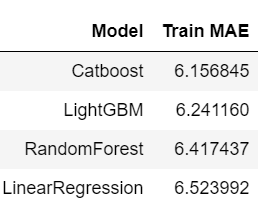
- Использовали кроссвалидации cv = 10.
- Хуже всего показал результат модель линейной регрессии. МАЕ = 6.52 при кросс-валидации.
- Лучшее значение MAE при кросс-валидации показала модель Catboost - 6.15, при гиперпараметрах 
    - learning_rate': 0.09, 'loss_function': 'MAE', 'n_estimators': 150

Тестирование:
- Итоговое MAE составляет *6.48** с помощью модели Catboost, что удовлетворяет условию поставленной задачи.
- MAE дамми-модели составляет 8.084, что больше чем у тестовой модели. Модель прошла проверку на адекватность.

Важными признаками является:
- Изначальная температура
- Работа, совершенная электродами
- Сыпучие материалы Wire 1
- Время простоя
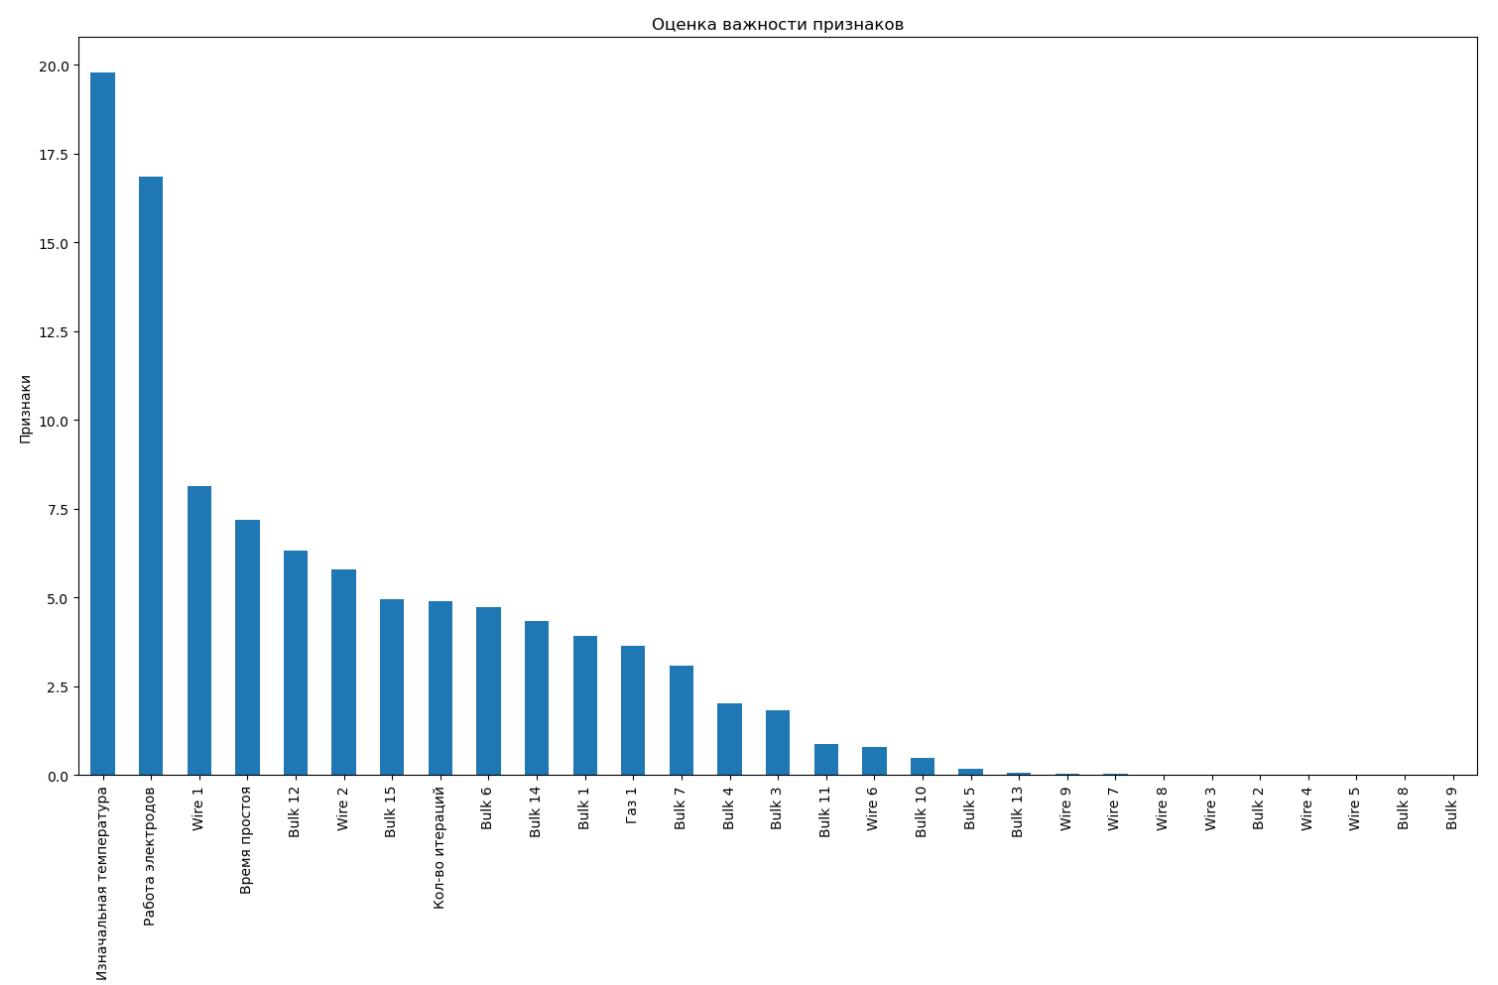

**Рекомендации**
- Взять большую выборку для обучения моделей, а именно где не будет простоев(у нас были простои в августе), и рабочие датчики, так как выявили одиночные замеры температуры, которые пришлось исключить. Итоговая выборка для обучения - 2325
- Имеются простои между итерациями при выполнении плавки, при уменьшении простоев можно сохранить температуру и сэкономить на нагревании
- Модель ошибается в среднем на 6,5 градусов, что позволяет предсказывать точность нагревания, а также использовать при моделировании.

## Отчет по решению

### Понимание производственного процесса и план

#### Определение цели проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.  

#### Область применения

При управлении нагревом можно будет подставлять разные параметры и смотреть на результат. И корректировать параметры так, чтобы избегать лишнего нагрева. Что позволит воспроизводить процесс(эксперимент) с помощью математической модели, и тестировать только лучшие результаты, также можем выделить наиболее важные признаки влияющие на нагрев и конечную температуру.

#### Описание этапа производства
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

#### План работы

1. Получить первичную информацию о данных;
2. Заменить типы данных, если потребуется
3. Проанализировать 1 этап плавки
4. Провести исследовательский анализ:
    - Построить графики ящик с усами, гистограммы
    - Исключить аномальные значения
    - Исключить плавки, у которых не зафиксирована темпереатура
    - Исключить плавки у которых температура ниже 1500(согласно дополнительным пояснениям)
5. Выявить структурную зависимость данных для подачи в модель:
    - Построить итоговую таблицу с признаками. Целевой признак - последняя температура.
    - Исключить плавки, где замер произведен 1 раз.
    - Выявить ненужные столбцы, заменить новыми. Исключить активную, реактувную мощность, а также время подачи сыпучих материалов и проволки
6. Задача по условию является задачей регрессии, для этого выполнил следующие этапы:
    - Масштабирование числовых значений для линейной регрессии
    - Выбор метрики для оценки качества модели. В нашем случае это MAE
    - Деление на тренировочную, тестовую выборку в отношении 75:25
    - Обучение модели на Gridsearchcv с кросс-валидацией и подбором гиперпараметров.
    - Модели: линейная регрессия, случайный лес, градиентный бустинг
    - Оценка качества моделей MAE. 
    - Тестирование модели с наименьшим MAE и сравнение с дамми-моделью. 
    - Итоговое MAE не более 6.8

Все пункты плана были выполнены.

#### Показатели

В модели использовали показа MAE - абсолютное отклонение. Даннный показатель легче интерпретировать при итоговой тестировании модели. MAE должно быть < 6.8

### Сбор, изучение, понимание данных

Перед нами задача регрессии, предсказание количественной величины (в нашем случае конечной температуры), в одной плавке.  

#### Описание данных

Для моделирования использовали следующие файлы, полученных из разных источников:  
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).  

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

До обработки данных перед моделированием было 3241 объектов.  

**Цель**: разработать модель прогноза температуры с абсолютным отклонением не более 6.8 градусов.  
**Характеристики**: 
- `data_arc.csv` — номер партии, Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность
- `data_bulk.csv` — партия, и подача сыпучих материлов 15 видов( с Bulk 1 до Bulk Bulk 15) в объеме
- `data_bulk_time.csv` — партия, и подача сыпучих материлов 15 видов( с Bulk 1 до Bulk Bulk 15) время подачи
- `data_gas.csv` — партия, объем подаваемого газа
- `data_temp.csv` — партия, время замера, Температура
- `data_wire.csv` — партия, вид подаваемой проволки (Wire 1 до Wire 9) в объеме
- `data_wire_time.csv` —  партия, вид подаваемой проволки (Wire 1 до Wire 9) по времени

#### Иследование и анализ данных

Измледование и анализ проводили с помощью библеотек `pandas`, `matplotlib`

В ходе анализа данных выяcнили:
- Анализ первой плавки:
    - Всего 1 плавка занимала 16 этапов вместе с замером температуры.
    - Между подаче Bulk 15 и замером температуры прошло 4 мин, хотя остальные этапы добавки более короткие
    - Во все время плавки было потрачено 29,74 у.е. газа
    - после каждого нагрева идет добавления материалов, на примере этой партии каждый раз одного материала, но есть партии где добавляется и сыпучии и проволочные вместе.
- В период с 14.07.2019 по 17.07.2019 производство не выполнялось, что подтверждает анализ каждого файла со временем. Пример, подача электричества на электроды:
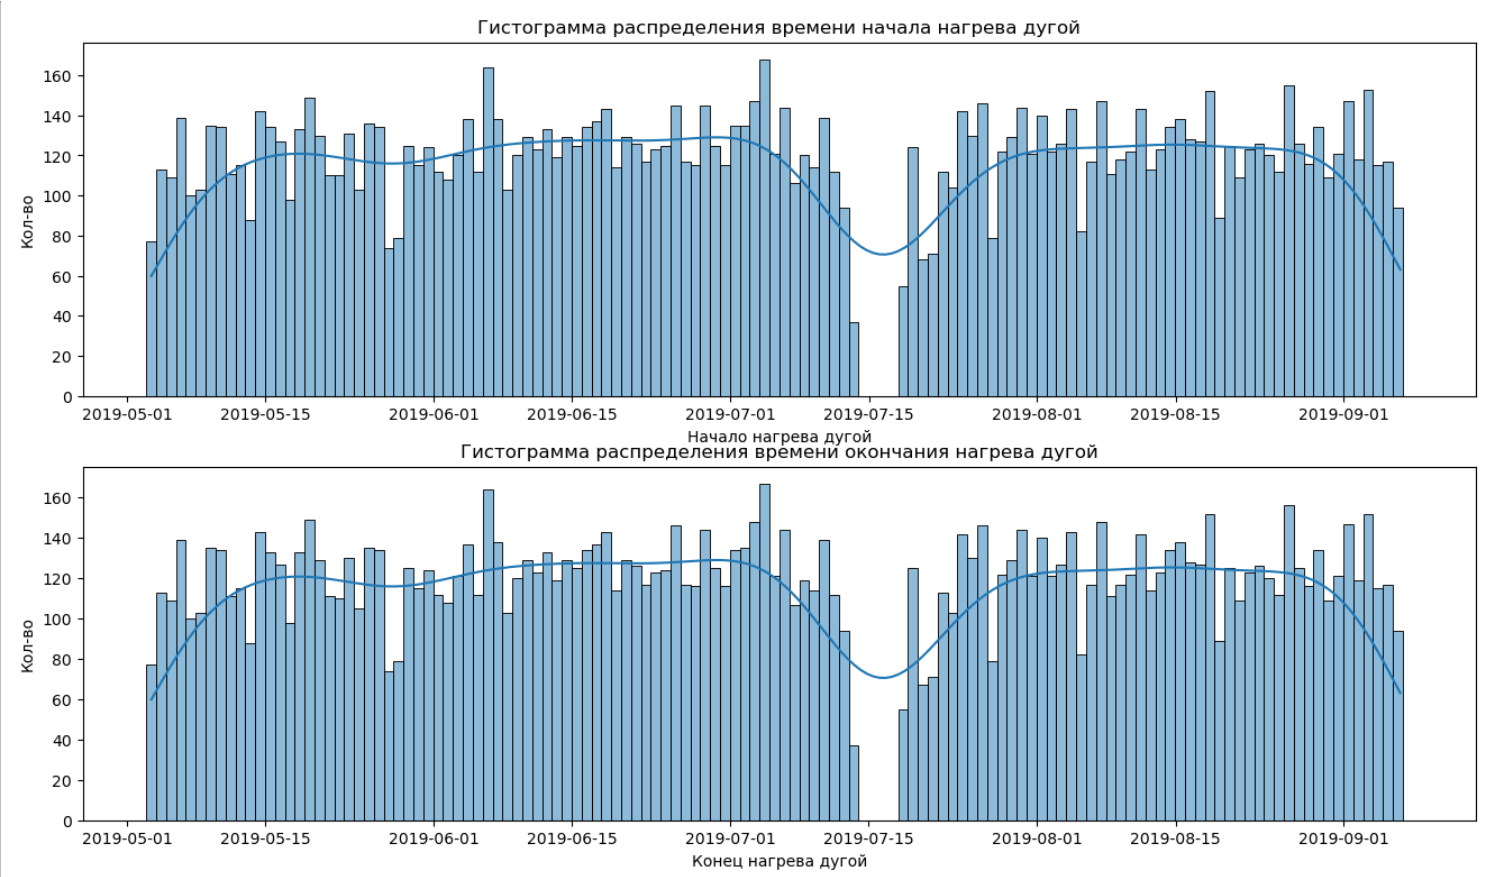
- Чаще всего нагревали 4 раза последовательно 1 плавку, максимальное кол-во итераций нагрева дуги 16, имеются единичные случаи
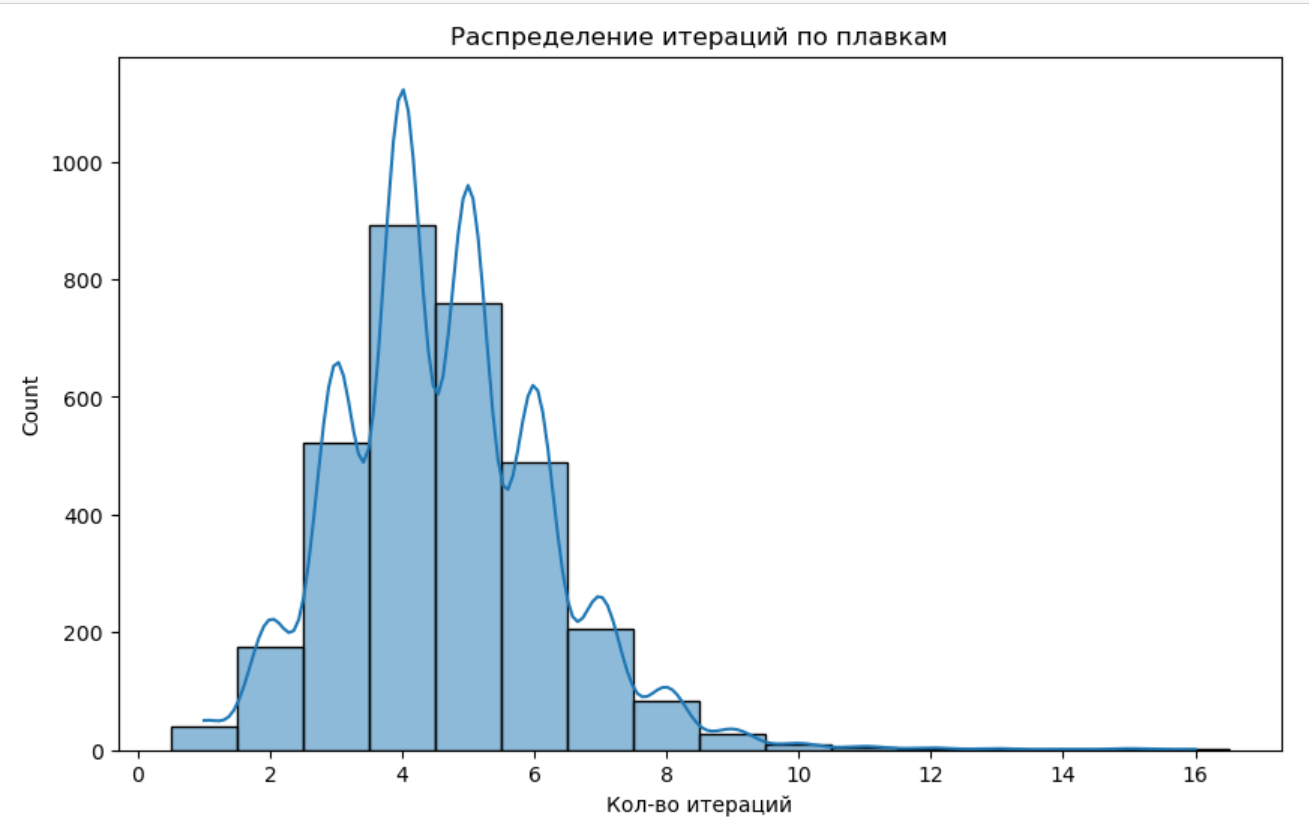
- отсутствовали подачи некоторых легирующих элементов в одну плавку, заменили на нулевое значение
- по условию, плавки, в которых температура была ниже 1500 градусов, составило 743 объекта. В дальнейшем исключили данные плавки.
- Распределение температуры в плавках нормальное, медиана - 1590
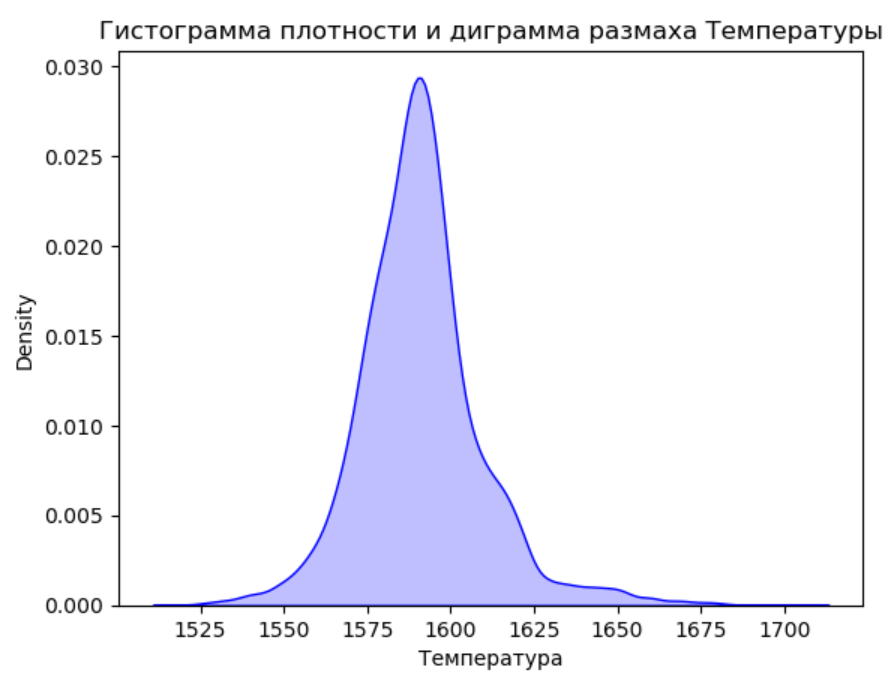
- Bulk 8 и Bulk 12 со значением 1849 у.е. - данные строчки исключаем из тренировочной выборки, так как bulk8 всего 1 строчка, что может повлиять на обучение, bulk12 слишком большое значение, тоже повлияет
- Имеются единичные случаи с потреблением газа на плавку объемом окло 80 и 60 у.е. Данные плавки оставим в датасете, будем считать уникальным производством
- По объему проволок: Wire 1 3055 раз, это видно из описания данных, Wire 5 меньше всего. Выбросы незначительные.


### Моделирование

#### Подготовка данных к моделированию

Перед процессом создания модели мы сделали следующее:
- `data_bulk_time.csv`, `data_wire_time.csv` данные таблицы не брали в моделирование, так как они содержат время подачи сыпучих материалов. Основное время между замерами содержала в себе таблица `data_temp.csv`
- Преобразовали столбцы типа object в datetime для удобства работы со временем
- исключили все плавки, где встречалась температура ниже 1500 градусов (итого 743 плавки)
- заполнили пропуски нулями в таблицах `data_bulk_volume`, `data_wire_volume`
- исключили плавки, в которых были единичные замеры температуры, а именно 195, 279. Так как замеры единичные, то последняя температура является изначальной, что не годится для модели

Создали итоговый набор признаков для моделирования:
- Создали дополнительные признаки:
    - Конечная температура (последний замер температуры)
    - Кол-во итераций замеров (кол-во замеров температуры)
    - Работа электродов, совершенная электродами (расчитали как полная мощность * время работы электродов) 
    - Время простоя, сек (время между первым замером и последним - время работы электродов)
- Исключили признаки:
    - `key`, для модели не важен номер плавки.
    - `Конец нагрева дугой`, `Начало нагрева дугой`, `Время замера` - это моменты времени, и не несут в себе информации для моделирования. Вместо них взяли время простоя и работу электродов
- Из тренировочной модели, при условии, что в неё попали нужные нам объекты, исключили bulk8 всего 1 строчка, что может повлиять на обучение, bulk12 слишком большое значение.
- в итоговую таблицу вошли 2325 объектов и 30 признаков.
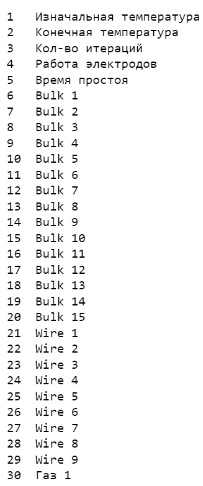

**Тренировочная выборка - 1742 строк  
Тестовая выборка - 582 строк**

#### Стандартизация числовы характеристик

В итоговом наборе данных отсуствуют категориальные значения, только количественныею Данные числовые характеристики были стандартизированы [предварительной обработкой Scikit-learn, функция Scaler()]("https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler") только для модели линейной регрессии, так как она чувствительна к большим числам.

####  Обучение модели

Мы создали 4 модели с 10-кратной перекрестной проверкой: Линейную регрессию, Случайный лес, LGBM, Catboost - лес решений, основанный на градиентном бустинге. Мы использовали все объекты из тренировочной выборки в качестве стратегии перекрестной выборки.

#### Оценка моделей

В качестве параметра оценки модели использовали MAE и получили следующую таблицу результатов:

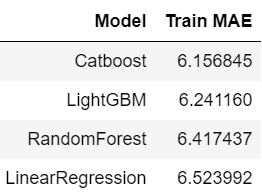
- Хуже всего показал результат модель линейной регрессии. МАЕ = 6.52 при кросс-валидации.
- Лучшее значение MAE при кросс-валидации показала модель Catboost - 6.15, при гиперпараметрах 
    - learning_rate': 0.09, 'loss_function': 'MAE', 'n_estimators': 150

Для итогового тестирования взяли модель Catboost.
- Итоговое MAE составляет **6.48** с помощью модели Catboost, что удовлетворяет условию поставленной задачи.

Важными характеристиками для обучения является:
- Изначальная температура
- Работа, совершенная электродами
- Сыпучие материалы Wire 1
- Время простоя
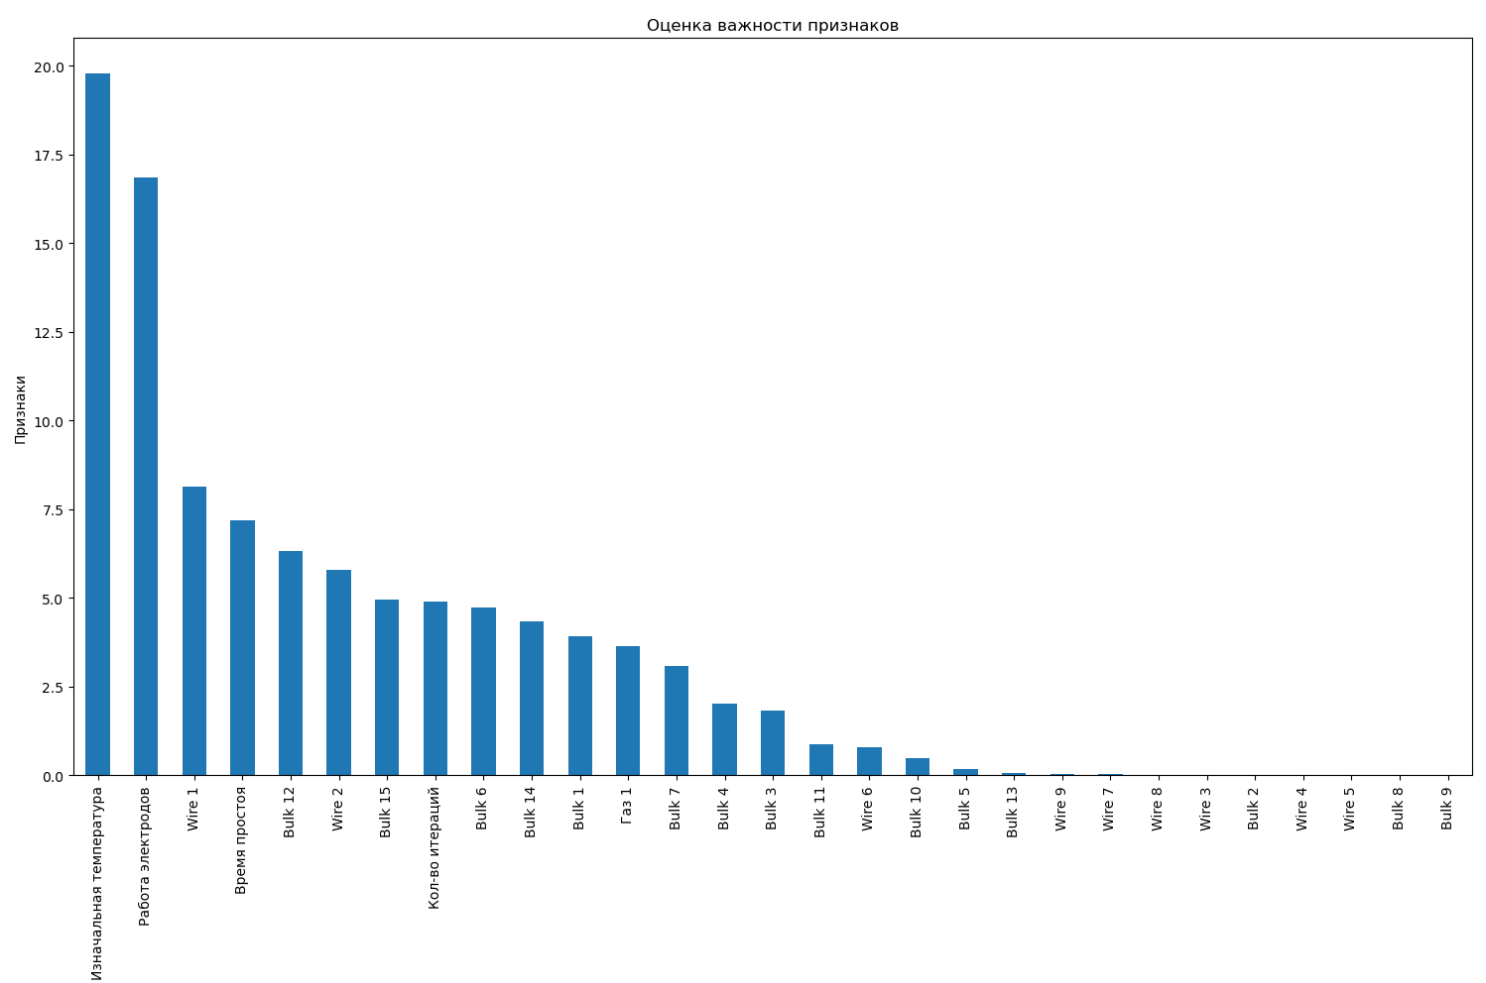

**Рекомендации**
- Взять большую выборку для обучения моделей, а именно где не будет простоев(у нас были простои в августе), и рабочие датчики, так как выявили одиночные замеры температуры, которые пришлось исключить. Итоговая выборка для обучения - 2325
- Имеются простои между итерациями при выполнении плавки, при уменьшении простоев можно сохранить температуру и сэкономить на нагревании
- Модель ошибается в среднем на 6,5 градусов, что позволяет предсказывать точность нагревания, а также использовать при моделировании.